###1. Import Libraries and Setup



In [ ]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from PIL import Image
from torchvision import models
import numpy as np
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR

from google.colab import drive
drive.mount('/content/drive',force_remount=True)

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Mounted at /content/drive
Using device: cuda


### Load Data and Prepare Dataset

In [ ]:
"""import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split

# Load the DataFrame containing filenames and labels
df = pd.read_csv('/content/drive/MyDrive/Data Science AUEB/Deep Learning/datasets/Other Useful/labeled wavs/final_labels.csv')

# Convert 'Filename' column to string to avoid any type issues
df['Filename'] = df['Filename'].astype(str)

# --- Patient-wise Split Logic (remains unchanged) ---

# 1. Get unique patient IDs and their corresponding diagnosis for stratification
patient_diagnoses = df.groupby('Patient ID')['Diagnosis'].first().reset_index()

# 2. Check the number of samples per diagnosis
diagnosis_counts = patient_diagnoses['Diagnosis'].value_counts()

# Identify diagnoses with fewer than 2 samples (problematic for direct stratified split)
small_classes = diagnosis_counts[diagnosis_counts < 2].index.tolist()

# Initialize lists to store patient IDs for each split
train_patient_ids_list = []
val_patient_ids_list = []
test_patient_ids_list = []

# Handle small classes separately: put them all in the training set
if small_classes:
    small_class_patients_df = patient_diagnoses[patient_diagnoses['Diagnosis'].isin(small_classes)]
    train_patient_ids_list.extend(small_class_patients_df['Patient ID'].tolist())
    # Exclude these patients from the pool for stratified splitting
    patients_for_stratified_pool_df = patient_diagnoses[~patient_diagnoses['Patient ID'].isin(small_class_patients_df['Patient ID'])]
else:
    patients_for_stratified_pool_df = patient_diagnoses.copy()

# Perform the first stratified split (Train vs. Temporary) on the refined pool
train_remaining_ids, temp_remaining_ids = [], []
if not patients_for_stratified_pool_df.empty:
    train_remaining_ids, temp_remaining_ids = train_test_split(
        patients_for_stratified_pool_df['Patient ID'],
        test_size=0.2,   # 20% for temp (validation + test)
        stratify=patients_for_stratified_pool_df['Diagnosis'],
        random_state=42
    )
    train_patient_ids_list.extend(train_remaining_ids.tolist())
    temp_patient_ids_df = patient_diagnoses[patient_diagnoses['Patient ID'].isin(temp_remaining_ids)].copy()
else:
    temp_patient_ids_df = pd.DataFrame() # No patients remaining for temp if pool was empty

# Before the second stratified split, check for small classes in the temporary pool
temp_diagnosis_counts = temp_patient_ids_df['Diagnosis'].value_counts()
small_classes_in_temp = temp_diagnosis_counts[temp_diagnosis_counts < 2].index.tolist()

if small_classes_in_temp:
    small_class_patients_in_temp_df = temp_patient_ids_df[temp_patient_ids_df['Diagnosis'].isin(small_classes_in_temp)]
    # Move these single-instance classes to the validation set
    val_patient_ids_list.extend(small_class_patients_in_temp_df['Patient ID'].tolist())
    # Exclude these patients from the temporary pool for further splitting
    temp_patients_for_split_df = temp_patient_ids_df[~temp_patient_ids_df['Patient ID'].isin(small_class_patients_in_temp_df['Patient ID'])]
else:
    temp_patients_for_split_df = temp_patient_ids_df.copy()

# Perform the second stratified split (Validation vs. Test) on the refined temp pool
val_remaining_ids, test_remaining_ids = [], []
if not temp_patients_for_split_df.empty:
    val_remaining_ids, test_remaining_ids = train_test_split(
        temp_patients_for_split_df['Patient ID'],
        test_size=0.5,   # 50% of temp is for test (10% of total)
        stratify=temp_patients_for_split_df['Diagnosis'],
        random_state=42
    )
    val_patient_ids_list.extend(val_remaining_ids.tolist())
    test_patient_ids_list.extend(test_remaining_ids.tolist())

# Combine initial assignments with stratified split results to get final patient ID lists
final_train_patient_ids = list(set(train_patient_ids_list))
final_val_patient_ids = list(set(val_patient_ids_list))
final_test_patient_ids = list(set(test_patient_ids_list))

# Create the final DataFrames using the split patient IDs
train_df = df[df['Patient ID'].isin(final_train_patient_ids)]
val_df = df[df['Patient ID'].isin(final_val_patient_ids)]
test_df = df[df['Patient ID'].isin(final_test_patient_ids)]

print("--- Initial Split Results (before Augmentation) ---")
print(f"\nTrain: {len(train_df)} samples, Validation: {len(val_df)} samples, Test: {len(test_df)} samples")
print(f"Unique patients in Train set: {len(set(train_df['Patient ID'].unique()))}")
print(f"Unique patients in Validation set: {len(set(val_df['Patient ID'].unique()))}")
print(f"Unique patients in Test set: {len(set(test_df['Patient ID'].unique()))}")
print(f"Overlap between Train and Validation patients: {len(set(train_df['Patient ID'].unique()).intersection(set(val_df['Patient ID'].unique())))}")
print(f"Overlap between Train and Test patients: {len(set(train_df['Patient ID'].unique()).intersection(set(test_df['Patient ID'].unique())))}")
print(f"Overlap between Validation and Test patients: {len(set(val_df['Patient ID'].unique()).intersection(set(test_df['Patient ID'].unique())))}")
print("\nDiagnosis distribution in Train set:")
print(train_df['Diagnosis'].value_counts(normalize=True))
print("\nDiagnosis distribution in Validation set:")
print(val_df['Diagnosis'].value_counts(normalize=True))
print("\nDiagnosis distribution in Test set:")
print(test_df['Diagnosis'].value_counts(normalize=True))

all_diagnoses = patient_diagnoses['Diagnosis'].unique().tolist()
print("\nMissing Diagnoses after Initial Split (Warnings are expected for very rare classes):")
for diagnosis in all_diagnoses:
    if diagnosis not in train_df['Diagnosis'].values:
        print(f"Warning: '{diagnosis}' is missing from Train set.")
    if diagnosis not in val_df['Diagnosis'].values:
        print(f"Warning: '{diagnosis}' is missing from Validation set.")
    if diagnosis not in test_df['Diagnosis'].values:
        print(f"Warning: '{diagnosis}' is missing from Test set.")




## Data Augmentation for Missing Diagnoses


# Function to apply conceptual jittering to a spectrogram array
def jitter_spectrogram(spectrogram_array):
    # Example jittering: adding random Gaussian noise
    # Adjust mean and standard deviation as needed for your specific data
    noise = np.random.normal(0, 0.05, spectrogram_array.shape)
    jittered_spec = spectrogram_array + noise

    # Clip values to be within 0-1 range, as plt.imsave expects this for float images
    jittered_spec = np.clip(jittered_spec, 0, 1)

    return jittered_spec

# Placeholder for spectrogram loading (in a real scenario, you'd load actual spectrogram data)
SPECTROGRAM_DIR = '/content/drive/My Drive/Data Science AUEB/Deep Learning/datasets/Spectrograms/Melspectrograms PNG/'
AUGMENTED_SPECTROGRAM_DIR = '/content/drive/My Drive/Data Science AUEB/Deep Learning/datasets/Spectrograms/Melspectrograms PNG/augmented/' # Directory to save augmented files

# Create the augmented spectrogram directory if it doesn't exist
os.makedirs(AUGMENTED_SPECTROGRAM_DIR, exist_ok=True)

# Function to simulate loading a spectrogram
def load_spectrogram(filename):
    # Ensure the filename ends with '.png' for loading spectrogram images
    if filename.endswith('.wav'):
        filename = filename[:-4]  # Remove '.wav'
    if not filename.endswith('.png'):
        filename += ".png"   # Add '.png' extension if not already present

    # Load and return the spectrogram image
    return plt.imread(os.path.join(SPECTROGRAM_DIR, filename))

# Lists to store augmented data rows (these will be full DataFrame rows)
augmented_val_rows = []
augmented_test_rows = []

# Initialize a global counter for augmented IDs, starting from 1
augmented_id_counter = 0

print("\n--- Starting Data Augmentation Process ---")

# Iterate through all unique diagnoses to identify and augment missing ones
for diagnosis in all_diagnoses:
    # --- Augment for Validation Set ---
    if diagnosis not in val_df['Diagnosis'].values:
        print(f"   Augmenting '{diagnosis}' for Validation set.")
        # Find original files for this diagnosis in the training set to serve as source
        source_files_df = train_df[train_df['Diagnosis'] == diagnosis]

        if not source_files_df.empty:
            num_augmentations = max(5, 10 - len(source_files_df))
            for i in range(num_augmentations):
                augmented_id_counter += 1 # Increment for each new augmented file

                # Pick a random original file entry (full row) from the training set for augmentation
                original_file_entry = source_files_df.sample(1, random_state=42+i).iloc[0]
                original_filename = original_file_entry['Filename']

                # Load original spectrogram (conceptually)
                spec_array = load_spectrogram(original_filename)

                # Apply jittering
                jittered_spec = jitter_spectrogram(spec_array)

                # Create new filename for the augmented sample, keeping base original name
                # and appending '_augmented_X' where X is the continuous ID
                original_filename_base = os.path.splitext(original_filename)[0]
                new_filename_png = f"{original_filename_base}_augmented_{augmented_id_counter}.png"

                # Save jittered_spec to the augmented directory
                plt.imsave(os.path.join(AUGMENTED_SPECTROGRAM_DIR, new_filename_png), jittered_spec)

                # Create a deep copy of the original row to inherit all its values
                augmented_row = original_file_entry.copy()
                # ONLY update the Filename and add the Augmented_ID
                augmented_row['Filename'] = new_filename_png
                augmented_row['Augmented_ID'] = augmented_id_counter
                augmented_row['Type'] = 'Augmented_Val' # Add a type column for traceability

                augmented_val_rows.append(augmented_row)
        else:
            print(f"    No source files for '{diagnosis}' in training set to augment for Validation. This indicates an extremely rare diagnosis.")

    # --- Augment for Test Set (similar logic to validation) ---
    if diagnosis not in test_df['Diagnosis'].values:
        print(f"   Augmenting '{diagnosis}' for Test set.")
        source_files_df = train_df[train_df['Diagnosis'] == diagnosis]

        if not source_files_df.empty:
            num_augmentations = max(5, 10 - len(source_files_df))
            for i in range(num_augmentations):
                augmented_id_counter += 1 # Increment for each new augmented file

                original_file_entry = source_files_df.sample(1, random_state=42+i+num_augmentations).iloc[0]
                original_filename = original_file_entry['Filename']

                spec_array = load_spectrogram(original_filename)
                jittered_spec = jitter_spectrogram(spec_array)

                original_filename_base = os.path.splitext(original_filename)[0]
                new_filename_png = f"{original_filename_base}_augmented_{augmented_id_counter}.png"

                plt.imsave(os.path.join(AUGMENTED_SPECTROGRAM_DIR, new_filename_png), jittered_spec)

                # Create a deep copy of the original row to inherit all its values
                augmented_row = original_file_entry.copy()
                # ONLY update the Filename and add the Augmented_ID
                augmented_row['Filename'] = new_filename_png
                augmented_row['Augmented_ID'] = augmented_id_counter
                augmented_row['Type'] = 'Augmented_Test' # Add a type column for traceability

                augmented_test_rows.append(augmented_row)
        else:
            print(f"    No source files for '{diagnosis}' in training set to augment for Test. This indicates an extremely rare diagnosis.")

# Convert lists of augmented rows into DataFrames
augmented_val_df = pd.DataFrame(augmented_val_rows)
augmented_test_df = pd.DataFrame(augmented_test_rows)

# Ensure new columns ('Augmented_ID', 'Type') exist in original DFs before concatenation
# Fill them with NaN for original data, as they only apply to augmented data.
for col in ['Augmented_ID', 'Type']:
    if col not in train_df.columns:
        train_df[col] = np.nan
    if col not in val_df.columns:
        val_df[col] = np.nan
    if col not in test_df.columns:
        test_df[col] = np.nan

# Assign 'Type' for original dataframes for clarity
train_df['Type'] = 'Original_Train'
val_df['Type'] = 'Original_Val'
test_df['Type'] = 'Original_Test'


# Concatenate augmented data with original validation and test sets
# Pandas will align columns by name, ensuring full metadata is preserved.
val_df_final = pd.concat([val_df, augmented_val_df], ignore_index=True)
test_df_final = pd.concat([test_df, augmented_test_df], ignore_index=True)


## Verification After Augmentation


print("\n--- Verification After Augmentation ---")
print(f"\nAugmented Validation Set: {len(val_df_final)} samples")
print(f"Augmented Test Set: {len(test_df_final)} samples")

print("\nDiagnosis distribution in Final Validation set:")
print(val_df_final['Diagnosis'].value_counts(normalize=True))
print("\nDiagnosis distribution in Final Test set:")
print(test_df_final['Diagnosis'].value_counts(normalize=True))

print("\nFinal check for missing diagnoses after augmentation:")
for diagnosis in all_diagnoses:
    if diagnosis not in val_df_final['Diagnosis'].values:
        print(f"Warning: '{diagnosis}' is STILL missing from Final Validation set. (This implies an issue with source data in train_df).")
    if diagnosis not in test_df_final['Diagnosis'].values:
        print(f"Warning: '{diagnosis}' is STILL missing from Final Test set. (This implies an issue with source data in train_df).")

# You would now use `train_df`, `val_df_final`, and `test_df_final` for your deep learning model training and evaluation.
train_df.to_csv('/content/drive/MyDrive/Data Science AUEB/Deep Learning/datasets/Other Useful/labeled wavs/train_df.csv', index=False)
val_df_final.to_csv('/content/drive/MyDrive/Data Science AUEB/Deep Learning/datasets/Other Useful/labeled wavs/val_df.csv', index=False)
test_df_final.to_csv('/content/drive/MyDrive/Data Science AUEB/Deep Learning/datasets/Other Useful/labeled wavs/test_df.csv', index=False)"""

'import pandas as pd\nimport numpy as np\nimport matplotlib.pyplot as plt\nimport os\nfrom sklearn.model_selection import train_test_split\n\n# Load the DataFrame containing filenames and labels\ndf = pd.read_csv(\'/content/drive/MyDrive/Data Science AUEB/Deep Learning/datasets/Other Useful/labeled wavs/final_labels.csv\')\n\n# Convert \'Filename\' column to string to avoid any type issues\ndf[\'Filename\'] = df[\'Filename\'].astype(str)\n\n# --- Patient-wise Split Logic (remains unchanged) ---\n\n# 1. Get unique patient IDs and their corresponding diagnosis for stratification\npatient_diagnoses = df.groupby(\'Patient ID\')[\'Diagnosis\'].first().reset_index()\n\n# 2. Check the number of samples per diagnosis\ndiagnosis_counts = patient_diagnoses[\'Diagnosis\'].value_counts()\n\n# Identify diagnoses with fewer than 2 samples (problematic for direct stratified split)\nsmall_classes = diagnosis_counts[diagnosis_counts < 2].index.tolist()\n\n# Initialize lists to store patient IDs for eac

In [ ]:
import pandas as pd

# Load the DataFrames
train_df = pd.read_csv('/content/drive/MyDrive/Data Science AUEB/Deep Learning/datasets/Other Useful/labeled wavs/train_df.csv')
val_df = pd.read_csv('/content/drive/MyDrive/Data Science AUEB/Deep Learning/datasets/Other Useful/labeled wavs/val_df.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Data Science AUEB/Deep Learning/datasets/Other Useful/labeled wavs/test_df.csv')


In [ ]:
train_df

,WAV File ID,Patient ID,Filename,Diagnosis,Domain,Domain_ID,Augmented_ID,Type
0,1.0,1.0,101_1b1_Al_sc_Meditron.wav,URTI,ICBHI,0,NaN,Original_Train
1,2.0,1.0,101_1b1_Pr_sc_Meditron.wav,URTI,ICBHI,0,NaN,Original_Train
2,3.0,2.0,102_1b1_Ar_sc_Meditron.wav,Healthy,ICBHI,0,NaN,Original_Train
3,4.0,3.0,103_2b2_Ar_mc_LittC2SE.wav,Asthma,ICBHI,0,NaN,Original_Train
4,5.0,4.0,104_1b1_Al_sc_Litt3200.wav,COPD,ICBHI,0,NaN,Original_Train
...,...,...,...,...,...,...,...,...
9777,475.0,64.0,164_1b1_Ll_sc_Meditron_snippet_4.wav_stretch_0...,URTI,ICBHI,0,NaN,Original_Train
9778,475.0,64.0,164_1b1_Ll_sc_Meditron_snippet_4.wav_stretch_0...,URTI,ICBHI,0,NaN,Original_Train
9779,475.0,64.0,164_1b1_Ll_sc_Meditron_snippet_4.wav_pitch_-2.wav,URTI,ICBHI,0,NaN,Original_Train
9780,475.0,64.0,164_1b1_Ll_sc_Meditron_snippet_4.wav_pitch_1.wav,URTI,ICBHI,0,NaN,Original_Train


In [ ]:
val_df

,WAV File ID,Patient ID,Filename,Diagnosis,Domain,Domain_ID,Augmented_ID,Type
0,12.0,6.0,106_2b1_Pl_mc_LittC2SE.wav,COPD,ICBHI,0,NaN,Original_Val
1,13.0,6.0,106_2b1_Pr_mc_LittC2SE.wav,COPD,ICBHI,0,NaN,Original_Val
2,72.0,15.0,115_1b1_Ar_sc_Meditron.wav,LRTI,ICBHI,0,NaN,Original_Val
3,83.0,19.0,119_1b1_Ar_sc_Meditron.wav,URTI,ICBHI,0,NaN,Original_Val
4,178.0,31.0,131_1b1_Al_sc_Meditron.wav,URTI,ICBHI,0,NaN,Original_Val
...,...,...,...,...,...,...,...,...
1376,944.0,134.0,"DP8_Plueral Effusion,I C B,P L L,70,M_snippet_...",Pleural Effusion,KAUH,1,16.0,Augmented_Val
1377,943.0,134.0,"EP8_Plueral Effusion,I C B,P L L,70,M_snippet_...",Pleural Effusion,KAUH,1,17.0,Augmented_Val
1378,942.0,134.0,"BP8_Plueral Effusion,I C B,P L L,70,M_snippet_...",Pleural Effusion,KAUH,1,18.0,Augmented_Val
1379,937.0,132.0,"DP6_Plueral Effusion,I C B,P L R,81,M_snippet_...",Pleural Effusion,KAUH,1,19.0,Augmented_Val


In [ ]:
test_df

,WAV File ID,Patient ID,Filename,Diagnosis,Domain,Domain_ID,Augmented_ID,Type
0,11.0,5.0,105_1b1_Tc_sc_Meditron.wav,URTI,ICBHI,0,NaN,Original_Test
1,14.0,7.0,107_2b3_Al_mc_AKGC417L.wav,COPD,ICBHI,0,NaN,Original_Test
2,15.0,7.0,107_2b3_Ar_mc_AKGC417L.wav,COPD,ICBHI,0,NaN,Original_Test
3,16.0,7.0,107_2b3_Ll_mc_AKGC417L.wav,COPD,ICBHI,0,NaN,Original_Test
4,17.0,7.0,107_2b3_Lr_mc_AKGC417L.wav,COPD,ICBHI,0,NaN,Original_Test
...,...,...,...,...,...,...,...,...
1200,944.0,134.0,"DP8_Plueral Effusion,I C B,P L L,70,M_snippet_...",Pleural Effusion,KAUH,1,21.0,Augmented_Test
1201,938.0,132.0,"BP6_Plueral Effusion,I C B,P L R,81,M_snippet_...",Pleural Effusion,KAUH,1,22.0,Augmented_Test
1202,937.0,132.0,"DP6_Plueral Effusion,I C B,P L R,81,M_snippet_...",Pleural Effusion,KAUH,1,23.0,Augmented_Test
1203,938.0,132.0,"BP6_Plueral Effusion,I C B,P L R,81,M_snippet_...",Pleural Effusion,KAUH,1,24.0,Augmented_Test


In [ ]:

# Check the split
print(f"\nTrain: {len(train_df)} samples, Validation: {len(val_df)} samples, Test: {len(test_df)} samples")

# Verify that no patient IDs overlap between sets
train_patients = set(train_df['Patient ID'].unique())
val_patients = set(val_df['Patient ID'].unique())
test_patients = set(test_df['Patient ID'].unique())

print(f"\nUnique patients in Train set: {len(train_patients)}")
print(f"Unique patients in Validation set: {len(val_patients)}")
print(f"Unique patients in Test set: {len(test_patients)}")

"""print(f"\nOverlap between Train and Validation patients: {len(train_patients.intersection(val_patients))}")
print(f"Overlap between Train and Test patients: {len(train_patients.intersection(test_patients))}")
print(f"Overlap between Validation and Test patients: {len(val_patients.intersection(test_patients))}")
"""
# Verify stratification by diagnosis in each set (optional, but good for checks)
print("\nDiagnosis distribution in Train set:")
print(train_df['Diagnosis'].value_counts(normalize=True))
print("\nDiagnosis distribution in Validation set:")
print(val_df['Diagnosis'].value_counts(normalize=True))
print("\nDiagnosis distribution in Test set:")
print(test_df['Diagnosis'].value_counts(normalize=True))

# Ensure all diagnoses are included in each set (even if some have only one sample)
diagnosis_counts = train_df['Diagnosis'].value_counts()  # Using train_df as the source for all diagnoses

for diagnosis in diagnosis_counts.index:
    if diagnosis not in train_df['Diagnosis'].values:
        print(f"Warning: '{diagnosis}' is missing from Train set.")
    if diagnosis not in val_df['Diagnosis'].values:
        print(f"Warning: '{diagnosis}' is missing from Validation set.")
    if diagnosis not in test_df['Diagnosis'].values:
        print(f"Warning: '{diagnosis}' is missing from Test set.")



Train: 9782 samples, Validation: 1381 samples, Test: 1205 samples

Unique patients in Train set: 196
Unique patients in Validation set: 28
Unique patients in Test set: 32

Diagnosis distribution in Train set:
Diagnosis
Healthy             0.326927
Asthma              0.235024
Pneumonia           0.125230
COPD                0.103149
URTI                0.063382
Bronchiectasis      0.046616
Lung Fibrosis       0.034962
Bronchiolitis       0.034860
Pleural Effusion    0.026682
LRTI                0.003169
Name: proportion, dtype: float64

Diagnosis distribution in Validation set:
Diagnosis
Healthy             0.360608
Bronchiectasis      0.156408
Asthma              0.123823
COPD                0.097755
Pneumonia           0.089066
Lung Fibrosis       0.056481
Bronchiolitis       0.044895
URTI                0.044895
LRTI                0.022448
Pleural Effusion    0.003621
Name: proportion, dtype: float64

Diagnosis distribution in Test set:
Diagnosis
Healthy             0.360166
Pneum

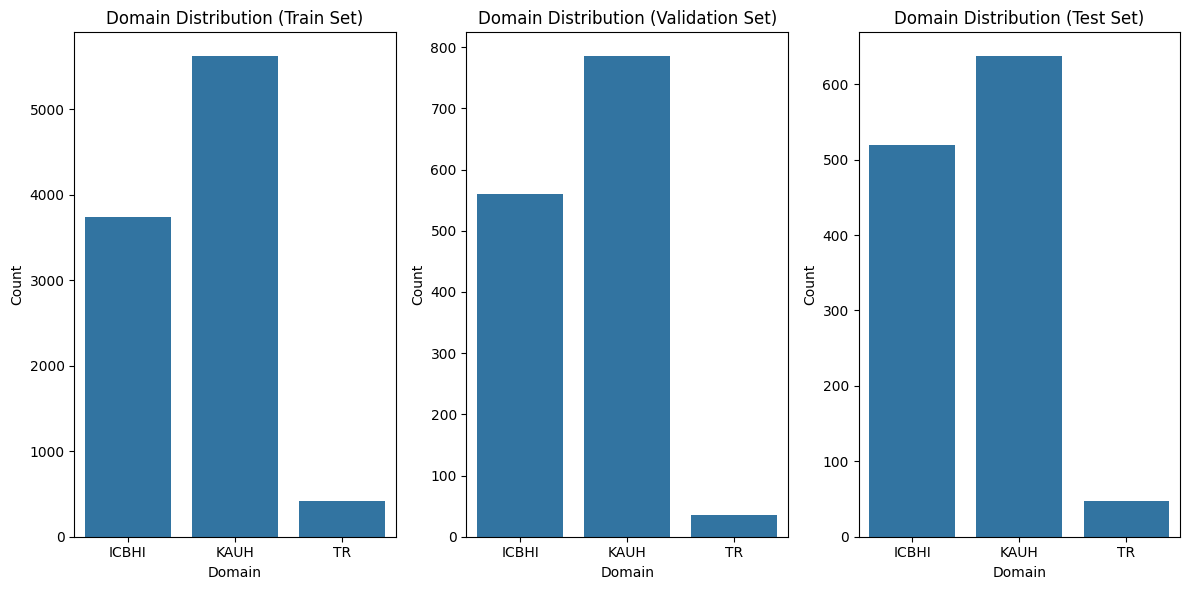


Number of Unique Patients per Diagnosis in Train Set:
          Diagnosis  Patient ID
0            Asthma          19
1    Bronchiectasis           8
2     Bronchiolitis           5
3              COPD          92
4           Healthy          45
5              LRTI           1
6     Lung Fibrosis           4
7  Pleural Effusion           2
8         Pneumonia           9
9              URTI          11

Number of Unique Patients per Diagnosis in Validation Set:
          Diagnosis  Patient ID
0            Asthma           2
1    Bronchiectasis           1
2     Bronchiolitis           1
3              COPD          12
4           Healthy           5
5              LRTI           1
6     Lung Fibrosis           1
7  Pleural Effusion           2
8         Pneumonia           1
9              URTI           2

Number of Unique Patients per Diagnosis in Test Set:
          Diagnosis  Patient ID
0            Asthma           3
1    Bronchiectasis           1
2     Bronchiolitis           2

<ipython-input-8-21207307aeb0>:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha="right")  # Rotate x-axis labels for Train plot
<ipython-input-8-21207307aeb0>:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")  # Rotate x-axis labels for Validation plot
<ipython-input-8-21207307aeb0>:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha="right")  # Rotate x-axis labels for Test plot


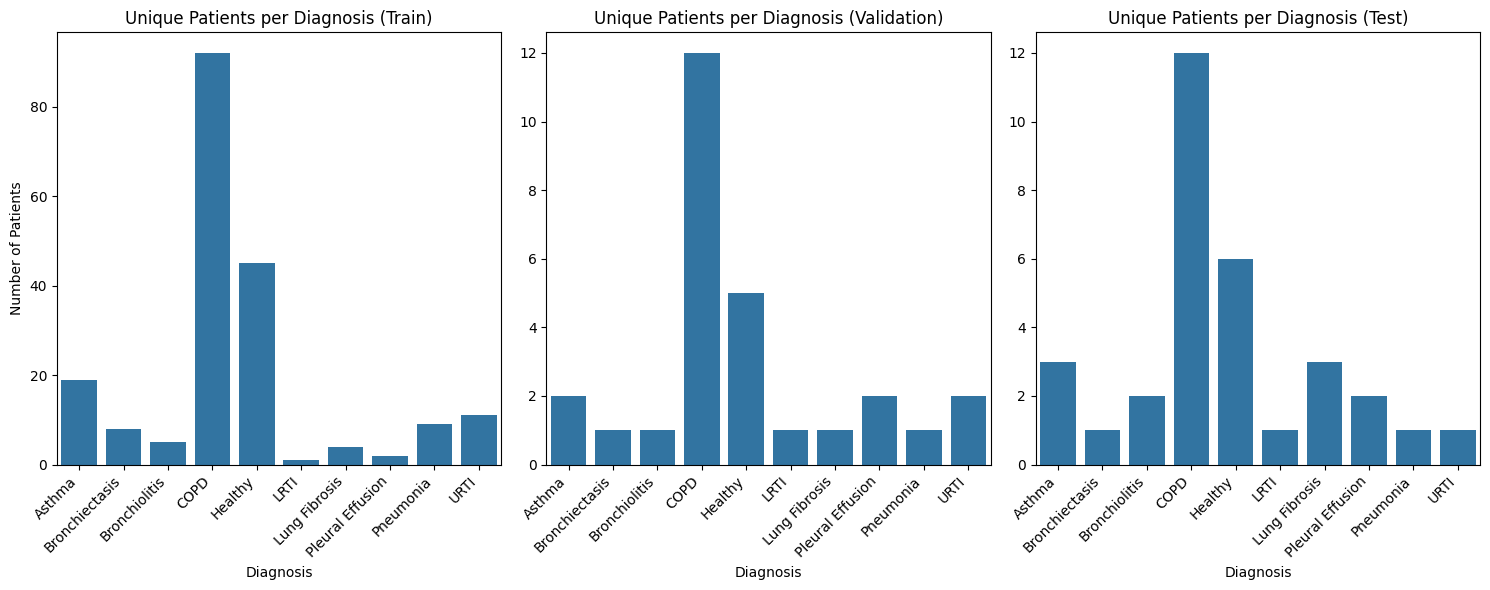

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Analysis of Data Distribution Across Domains ---

# Plotting the distribution of Diagnosis in each set
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
sns.countplot(x='Domain', data=train_df)
plt.title('Domain Distribution (Train Set)')
plt.xlabel('Domain')
plt.ylabel('Count')

plt.subplot(1, 3, 2)
sns.countplot(x='Domain', data=val_df)
plt.title('Domain Distribution (Validation Set)')
plt.xlabel('Domain')
plt.ylabel('Count')

plt.subplot(1, 3, 3)
sns.countplot(x='Domain', data=test_df)
plt.title('Domain Distribution (Test Set)')
plt.xlabel('Domain')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Plotting the distribution of Patient IDs per Diagnosis in each set
# This is more complex and might require a different visualization approach
# Here's a simplified approach showing the number of unique patients per diagnosis per set

patient_diagnosis_counts_train = train_df.groupby('Diagnosis')['Patient ID'].nunique().reset_index()
patient_diagnosis_counts_val = val_df.groupby('Diagnosis')['Patient ID'].nunique().reset_index()
patient_diagnosis_counts_test = test_df.groupby('Diagnosis')['Patient ID'].nunique().reset_index()

print("\nNumber of Unique Patients per Diagnosis in Train Set:")
print(patient_diagnosis_counts_train)
print("\nNumber of Unique Patients per Diagnosis in Validation Set:")
print(patient_diagnosis_counts_val)
print("\nNumber of Unique Patients per Diagnosis in Test Set:")
print(patient_diagnosis_counts_test)

fig, axes = plt.subplots(1, 3, figsize=(15, 6))

# Plot for Train
sns.barplot(x='Diagnosis', y='Patient ID', data=patient_diagnosis_counts_train, ax=axes[0])
axes[0].set_title('Unique Patients per Diagnosis (Train)')
axes[0].set_ylabel('Number of Patients')
axes[0].tick_params(axis='x', labelsize=10)  # Set the size of the x-axis labels
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha="right")  # Rotate x-axis labels for Train plot

# Plot for Validation
sns.barplot(x='Diagnosis', y='Patient ID', data=patient_diagnosis_counts_val, ax=axes[1])
axes[1].set_title('Unique Patients per Diagnosis (Validation)')
axes[1].set_ylabel('')  # Hide y-label for subplots 2 and 3
axes[1].tick_params(axis='x', labelsize=10)  # Set the size of the x-axis labels
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")  # Rotate x-axis labels for Validation plot

# Plot for Test
sns.barplot(x='Diagnosis', y='Patient ID', data=patient_diagnosis_counts_test, ax=axes[2])
axes[2].set_title('Unique Patients per Diagnosis (Test)')
axes[2].set_ylabel('')  # Hide y-label for subplots 2 and 3
axes[2].tick_params(axis='x', labelsize=10)  # Set the size of the x-axis labels
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha="right")  # Rotate x-axis labels for Test plot

# Display the plot
plt.tight_layout()
plt.show()


### Custom Dataset Class for Lung Sound Spectrograms

### Data Transforms and DataLoader

In [ ]:
import os
from PIL import Image

class LungSoundDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        """
        Args:
            df (DataFrame): DataFrame containing filenames and labels.
            img_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

        # Dynamically create the class label mapping based on unique diagnoses
        self.class_mapping = {
            'Asthma': 0, 'Lung Fibrosis': 1, 'Healthy': 2, 'Pneumonia': 3,
            'Bronchiolitis': 4, 'COPD': 5, 'URTI': 6, 'Pleural Effusion': 7,
            'Bronchiectasis': 8, 'LRTI': 9
        }

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        filename = self.df.iloc[idx]['Filename']

        # Remove the '.wav' extension from the filename
        filename_no_extension = os.path.splitext(filename)[0]

        label = self.df.iloc[idx]['Diagnosis']

        # Construct the full image path (assuming images are named after the filenames without extensions)
        img_path = os.path.join(self.img_dir, f"{filename_no_extension}.png")

        # Check if the file exists before trying to open it
        if not os.path.exists(img_path):
            print(f"Error opening file: {img_path}")
            return None  # Skip this item if the file doesn't exist

        # Open the image and convert it
        image = Image.open(img_path).convert('RGB')

        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)

        # Return the image and its corresponding label
        return image, self.class_mapping.get(label, -1)  # -1 for unknown labels
from sklearn.utils.class_weight import compute_class_weight
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Pretrained model norms
])

# Define paths
img_dir = '/content/drive/My Drive/Data Science AUEB/Deep Learning/datasets/Spectrograms/Melspectrograms PNG'

# Create the datasets and dataloaders
train_dataset = LungSoundDataset(train_df, img_dir, transform)
val_dataset = LungSoundDataset(val_df, img_dir, transform)
test_dataset = LungSoundDataset(test_df, img_dir, transform)

# Optimizing DataLoader with more workers for faster data loading
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=8, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=8, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=8, pin_memory=True)

# --- Calculate class weights ---
class_weights = compute_class_weight(
    'balanced',
    classes=train_df['Diagnosis'].unique(),
    y=train_df['Diagnosis']
)
weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)


### Model Definitions

#### Custom CNN (Baseline)

In [ ]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


### Pretrained Models (ResNet50, DenseNet121)



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models as tv_models # <--- Changed here to use an alias

# --- Residual Block Class ---
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_rate=0.5):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Linear(in_channels, out_channels)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.conv2 = nn.Linear(out_channels, out_channels)
        self.bn2 = nn.BatchNorm1d(out_channels)

        # Identity shortcut (for residual connection)
        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Linear(in_channels, out_channels),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        residual = self.shortcut(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.conv2(x)
        x = self.bn2(x)

        # Add residual (skip connection)
        x += residual
        return x

# --- Pretrained Model Architectures (ResNet50, DenseNet121) with Residual Block ---
class PretrainedModel(nn.Module):
    def __init__(self, model_name, num_classes=10, dropout_rate=0.5, input_channels=1):
        super(PretrainedModel, self).__init__()

        if model_name == 'resnet50':
            self.model = tv_models.resnet50(pretrained=True) # <--- Using tv_models
            # Adapt the first convolutional layer for 1 input channel
            original_conv1 = self.model.conv1
            self.model.conv1 = nn.Conv2d(input_channels, original_conv1.out_channels,
                                         kernel_size=original_conv1.kernel_size,
                                         stride=original_conv1.stride,
                                         padding=original_conv1.padding,
                                         bias=original_conv1.bias)

            self.feature_extractor = nn.Sequential(*list(self.model.children())[:-1])
            in_features = self.model.fc.in_features

        elif model_name == 'densenet121':
            self.model = tv_models.densenet121(pretrained=True) # <--- Using tv_models
            # Adapt the first convolutional layer for 1 input channel
            original_conv0 = self.model.features.conv0
            self.model.features.conv0 = nn.Conv2d(input_channels, original_conv0.out_channels,
                                                  kernel_size=original_conv0.kernel_size,
                                                  stride=original_conv0.stride,
                                                  padding=original_conv0.padding,
                                                  bias=original_conv0.bias)

            self.feature_extractor = self.model.features
            in_features = self.model.classifier.in_features

        else:
            raise ValueError(f"Model {model_name} not supported.")

        # Label Classifier with Residual Block
        self.label_classifier = nn.Sequential(
            ResidualBlock(in_features, in_features // 2, dropout_rate),  # Residual Block
            nn.Linear(in_features // 2, num_classes)
        )

    def forward(self, x):
        features = self.feature_extractor(x)

        # Apply global average pooling
        # Ensure you use tv_models here as well
        if isinstance(self.model, tv_models.ResNet): # <--- Corrected
            features = F.adaptive_avg_pool2d(features, (1, 1))
        elif isinstance(self.model, tv_models.DenseNet): # <--- Corrected
            features = F.relu(features, inplace=True)
            features = F.adaptive_avg_pool2d(features, (1, 1))

        features = features.view(features.size(0), -1)  # Flatten

        # Label classification with residual block
        output = self.label_classifier[0](features)  # Residual block
        output = self.label_classifier[1](output)    # Final output

        return output

### Train and Evaluate

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
from tqdm.auto import tqdm
import pandas as pd
from sklearn.metrics import accuracy_score

class_names = ['Healthy', 'Asthma', 'Pneumonia', 'COPD', 'Bronchiectasis', 'URTI',
               'Lung Fibrosis', 'Bronchiolitis', 'Pleural Effusion', 'LRTI']

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10, patience=5, device='cuda', class_names=None):
    best_val_acc = 0
    epochs_without_improvement = 0
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    train_f1_scores = []
    val_f1_scores = []

    # Use automatic mixed precision (AMP) for faster training if CUDA is available
    scaler = torch.amp.GradScaler('cuda')

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        all_train_labels = []
        all_train_preds = []

        # Training loop
        train_iter = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]", leave=True)
        for inputs, labels in train_iter:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            if scaler:  # Use mixed precision if scaler is initialized
                with torch.amp.autocast('cuda'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:  # Standard training if no scaler (e.g., on CPU)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

            running_train_loss += loss.item()

            # Collect predictions and labels for metrics calculation
            _, preds = torch.max(outputs, 1)
            all_train_labels.extend(labels.cpu().numpy())
            all_train_preds.extend(preds.cpu().numpy())

        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Calculate train accuracy and F1 score
        train_accuracy = accuracy_score(all_train_labels, all_train_preds)
        train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted')
        train_accuracies.append(train_accuracy)
        train_f1_scores.append(train_f1)

        print(f"\n--- Epoch {epoch+1} Training Metrics ---")
        print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Train F1 Score: {train_f1:.4f}")
        print("\nTraining Classification Report:")
        print(classification_report(all_train_labels, all_train_preds, target_names=class_names, zero_division=0))


        # Validation loop
        model.eval()
        running_val_loss = 0.0
        all_val_labels = []
        all_val_preds = []

        val_iter = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]", leave=True)
        with torch.no_grad():
            for inputs, labels in val_iter:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                all_val_labels.extend(labels.cpu().numpy())
                all_val_preds.extend(preds.cpu().numpy())

        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # Calculate validation accuracy and F1 score
        val_accuracy = accuracy_score(all_val_labels, all_val_preds)
        val_f1 = f1_score(all_val_labels, all_val_preds, average='weighted')
        val_accuracies.append(val_accuracy)
        val_f1_scores.append(val_f1)

        # Scheduler step (ReduceLROnPlateau)
        scheduler.step(avg_val_loss)

        # Print validation statistics and classification report
        print(f"\n--- Epoch {epoch+1} Validation Metrics ---")
        print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Validation F1 Score: {val_f1:.4f}")
        print("\nValidation Classification Report:")
        print(classification_report(all_val_labels, all_val_preds, target_names=class_names, zero_division=0))

        # Early stopping based on validation accuracy
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            epochs_without_improvement = 0
            print(f"\nImprovement detected in validation accuracy: {best_val_acc:.4f}. Resetting patience.")
        else:
            epochs_without_improvement += 1
            print(f"\nNo improvement in validation accuracy. Patience: {epochs_without_improvement}/{patience}")

        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}. No improvement for {patience} epochs.")
            break
        print('=' * 70)  # Separator for epochs

    print("\n--- Training Complete ---")

    # Plot results after training completes
    plot_training_results(train_losses, val_losses, val_accuracies)
    plot_test_confusion_matrix(model, val_loader, device, class_names)

    return train_losses, val_losses, train_accuracies, val_accuracies, train_f1_scores, val_f1_scores


def plot_confusion_matrix(y_true, y_pred, class_names):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(class_names)))

    # Create a heatmap with a smaller figure size for the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', cbar=False,
                xticklabels=class_names, yticklabels=class_names)

    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=30)
    plt.yticks()
    plt.tight_layout()
    plt.show()


def plot_test_confusion_matrix(model, test_loader, device, class_names):
    # Evaluate the model on the test set
    model.eval()
    all_test_labels = []
    all_test_preds = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_test_labels.extend(labels.cpu().numpy())
            all_test_preds.extend(preds.cpu().numpy())

    # Plot confusion matrix for test results
    plot_confusion_matrix(all_test_labels, all_test_preds, class_names)


def plot_training_results(train_losses, val_losses, val_accuracies):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Plot Losses
    axs[0].plot(train_losses, label='Training Loss', color='blue', marker='o')
    axs[0].plot(val_losses, label='Validation Loss', color='red', marker='x')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].set_title('Training and Validation Losses')
    axs[0].legend()
    axs[0].grid(True)

    # Plot Accuracy
    axs[1].plot(val_accuracies, label='Validation Accuracy', color='green', marker='o')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_title('Validation Accuracy Over Epochs')
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()


def evaluate_model(model, test_loader, device, class_names):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # Compute metrics using zero_division=0 to handle cases where a class has no predicted samples
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

    print(f"Accuracy: {round(accuracy, 4)}")
    print(f"Precision: {round(precision, 4)}")
    print(f"Recall: {round(recall, 4)}")
    print(f"F1 Score: {round(f1, 4)}")

    # Print Classification Report
    print("\nTest Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))

    # Plot confusion matrix for the test set
    plot_test_confusion_matrix(model, test_loader, device, class_names)

    return accuracy, f1


### Final Model Training and Evaluation

In [ ]:
num_epochs=100
patience=10

###CustomCNN

In [ ]:
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim import AdamW
import torch.optim as optim


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
custom_cnn_model = CustomCNN(num_classes=10).to(device)



Training CustomCNN...


Epoch 1/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 1 Training Metrics ---
Train Loss: 1.7466, Train Accuracy: 0.2193, Train F1 Score: 0.1447

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.30      0.71      0.43      2299
          Asthma       0.00      0.00      0.00       342
       Pneumonia       0.40      0.00      0.00      3198
            COPD       0.31      0.01      0.03      1225
  Bronchiectasis       0.06      0.69      0.12       341
            URTI       0.43      0.22      0.29      1009
   Lung Fibrosis       0.00      0.00      0.00       620
   Bronchiolitis       0.00      0.00      0.00       261
Pleural Effusion       0.35      0.07      0.12       456
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.22      9782
       macro avg       0.19      0.17      0.10      9782
    weighted avg       0.30      0.22      0.14      9782



Epoch 1/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 1 Validation Metrics ---
Validation Loss: 2.5326, Validation Accuracy: 0.1970, Validation F1 Score: 0.1057

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.22      0.68      0.33       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       1.00      0.00      0.00       498
            COPD       0.00      0.00      0.00       123
  Bronchiectasis       0.09      0.97      0.17        62
            URTI       0.48      0.70      0.57       135
   Lung Fibrosis       0.00      0.00      0.00        62
   Bronchiolitis       0.00      0.00      0.00         5
Pleural Effusion       0.00      0.00      0.00       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.20      1381
       macro avg       0.18      0.24      0.11      1381
    weighted avg       0.44      0.20      0.11      1381


Improvement detected in validat

Epoch 2/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 2 Training Metrics ---
Train Loss: 1.0918, Train Accuracy: 0.3937, Train F1 Score: 0.3143

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.39      0.87      0.54      2299
          Asthma       0.00      0.00      0.00       342
       Pneumonia       0.52      0.05      0.09      3198
            COPD       0.49      0.24      0.32      1225
  Bronchiectasis       0.16      0.93      0.28       341
            URTI       0.74      0.84      0.79      1009
   Lung Fibrosis       0.44      0.03      0.05       620
   Bronchiolitis       0.17      0.16      0.16       261
Pleural Effusion       0.55      0.38      0.45       456
            LRTI       0.33      0.06      0.11        31

        accuracy                           0.39      9782
       macro avg       0.38      0.36      0.28      9782
    weighted avg       0.46      0.39      0.31      9782



Epoch 2/1000 [Validation]:   0%|          | 0/87 [00:40<?, ?it/s]


--- Epoch 2 Validation Metrics ---
Validation Loss: 1.9822, Validation Accuracy: 0.2469, Validation F1 Score: 0.1786

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.20      0.81      0.32       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.59      0.02      0.04       498
            COPD       0.02      0.02      0.02       123
  Bronchiectasis       0.13      0.77      0.23        62
            URTI       0.62      0.76      0.68       135
   Lung Fibrosis       0.38      0.05      0.09        62
   Bronchiolitis       0.50      0.20      0.29         5
Pleural Effusion       0.64      0.17      0.26       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.25      1381
       macro avg       0.31      0.28      0.19      1381
    weighted avg       0.42      0.25      0.18      1381


Improvement detected in validat

Epoch 3/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 3 Training Metrics ---
Train Loss: 0.8429, Train Accuracy: 0.4875, Train F1 Score: 0.4347

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.44      0.86      0.58      2299
          Asthma       0.00      0.00      0.00       342
       Pneumonia       0.63      0.13      0.22      3198
            COPD       0.61      0.50      0.55      1225
  Bronchiectasis       0.25      0.94      0.40       341
            URTI       0.78      0.89      0.83      1009
   Lung Fibrosis       0.49      0.22      0.31       620
   Bronchiolitis       0.31      0.48      0.38       261
Pleural Effusion       0.60      0.55      0.57       456
            LRTI       0.27      0.42      0.33        31

        accuracy                           0.49      9782
       macro avg       0.44      0.50      0.42      9782
    weighted avg       0.54      0.49      0.43      9782



Epoch 3/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 3 Validation Metrics ---
Validation Loss: 2.4705, Validation Accuracy: 0.2773, Validation F1 Score: 0.2520

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.20      0.72      0.32       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.39      0.05      0.08       498
            COPD       0.02      0.04      0.03       123
  Bronchiectasis       0.12      0.19      0.15        62
            URTI       0.82      0.73      0.78       135
   Lung Fibrosis       0.25      0.65      0.36        62
   Bronchiolitis       0.19      0.60      0.29         5
Pleural Effusion       0.90      0.36      0.51       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.28      1381
       macro avg       0.29      0.33      0.25      1381
    weighted avg       0.41      0.28      0.25      1381


Improvement detected in validat

Epoch 4/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 4 Training Metrics ---
Train Loss: 0.5667, Train Accuracy: 0.6105, Train F1 Score: 0.5800

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.51      0.88      0.64      2299
          Asthma       0.00      0.00      0.00       342
       Pneumonia       0.75      0.31      0.44      3198
            COPD       0.72      0.67      0.69      1225
  Bronchiectasis       0.42      0.96      0.59       341
            URTI       0.87      0.94      0.90      1009
   Lung Fibrosis       0.64      0.52      0.58       620
   Bronchiolitis       0.42      0.67      0.52       261
Pleural Effusion       0.67      0.77      0.72       456
            LRTI       0.44      0.87      0.58        31

        accuracy                           0.61      9782
       macro avg       0.54      0.66      0.57      9782
    weighted avg       0.64      0.61      0.58      9782



Epoch 4/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 4 Validation Metrics ---
Validation Loss: 2.7904, Validation Accuracy: 0.3331, Validation F1 Score: 0.3103

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.24      0.60      0.35       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.49      0.37      0.42       498
            COPD       0.00      0.00      0.00       123
  Bronchiectasis       0.12      0.32      0.17        62
            URTI       0.60      0.76      0.67       135
   Lung Fibrosis       0.35      0.40      0.38        62
   Bronchiolitis       0.06      0.80      0.11         5
Pleural Effusion       0.32      0.11      0.16       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.33      1381
       macro avg       0.22      0.34      0.23      1381
    weighted avg       0.34      0.33      0.31      1381


Improvement detected in validat

Epoch 5/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ab4689f00e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ab4689f00e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16


--- Epoch 5 Training Metrics ---
Train Loss: 0.3244, Train Accuracy: 0.7442, Train F1 Score: 0.7263

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.61      0.90      0.72      2299
          Asthma       0.94      0.05      0.09       342
       Pneumonia       0.84      0.52      0.64      3198
            COPD       0.82      0.84      0.83      1225
  Bronchiectasis       0.75      0.99      0.85       341
            URTI       0.92      0.97      0.94      1009
   Lung Fibrosis       0.79      0.83      0.81       620
   Bronchiolitis       0.58      0.86      0.70       261
Pleural Effusion       0.81      0.95      0.87       456
            LRTI       0.67      0.90      0.77        31

        accuracy                           0.74      9782
       macro avg       0.77      0.78      0.72      9782
    weighted avg       0.78      0.74      0.73      9782



Epoch 5/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 5 Validation Metrics ---
Validation Loss: 2.9488, Validation Accuracy: 0.3049, Validation F1 Score: 0.2966

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.24      0.59      0.34       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.45      0.29      0.35       498
            COPD       0.04      0.06      0.05       123
  Bronchiectasis       0.07      0.15      0.09        62
            URTI       0.66      0.78      0.71       135
   Lung Fibrosis       0.25      0.37      0.30        62
   Bronchiolitis       0.11      0.60      0.18         5
Pleural Effusion       0.68      0.13      0.22       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.30      1381
       macro avg       0.25      0.30      0.22      1381
    weighted avg       0.38      0.30      0.30      1381


No improvement in validation ac

Epoch 6/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 6 Training Metrics ---
Train Loss: 0.3845, Train Accuracy: 0.7502, Train F1 Score: 0.7396

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.64      0.91      0.75      2299
          Asthma       0.90      0.13      0.23       342
       Pneumonia       0.86      0.56      0.68      3198
            COPD       0.85      0.81      0.83      1225
  Bronchiectasis       0.52      0.96      0.68       341
            URTI       0.90      0.95      0.93      1009
   Lung Fibrosis       0.80      0.74      0.77       620
   Bronchiolitis       0.57      0.86      0.68       261
Pleural Effusion       0.81      0.89      0.85       456
            LRTI       0.61      0.87      0.72        31

        accuracy                           0.75      9782
       macro avg       0.75      0.77      0.71      9782
    weighted avg       0.79      0.75      0.74      9782



Epoch 6/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 6 Validation Metrics ---
Validation Loss: 2.5409, Validation Accuracy: 0.3027, Validation F1 Score: 0.2834

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.24      0.64      0.35       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.50      0.28      0.36       498
            COPD       0.04      0.04      0.04       123
  Bronchiectasis       0.13      0.45      0.21        62
            URTI       0.59      0.70      0.64       135
   Lung Fibrosis       0.29      0.29      0.29        62
   Bronchiolitis       0.10      1.00      0.18         5
Pleural Effusion       0.50      0.08      0.14       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.30      1381
       macro avg       0.24      0.35      0.22      1381
    weighted avg       0.37      0.30      0.28      1381


No improvement in validation ac

Epoch 7/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 7 Training Metrics ---
Train Loss: 0.2860, Train Accuracy: 0.7996, Train F1 Score: 0.7918

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.70      0.93      0.80      2299
          Asthma       0.91      0.25      0.39       342
       Pneumonia       0.89      0.64      0.74      3198
            COPD       0.86      0.87      0.87      1225
  Bronchiectasis       0.62      0.97      0.76       341
            URTI       0.92      0.96      0.94      1009
   Lung Fibrosis       0.84      0.82      0.83       620
   Bronchiolitis       0.69      0.91      0.79       261
Pleural Effusion       0.80      0.92      0.85       456
            LRTI       0.88      0.97      0.92        31

        accuracy                           0.80      9782
       macro avg       0.81      0.82      0.79      9782
    weighted avg       0.82      0.80      0.79      9782



Epoch 7/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 7 Validation Metrics ---
Validation Loss: 3.0044, Validation Accuracy: 0.3085, Validation F1 Score: 0.2844

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.25      0.81      0.38       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.50      0.21      0.29       498
            COPD       0.09      0.07      0.08       123
  Bronchiectasis       0.13      0.39      0.20        62
            URTI       0.61      0.74      0.67       135
   Lung Fibrosis       0.18      0.15      0.16        62
   Bronchiolitis       0.12      0.80      0.21         5
Pleural Effusion       0.60      0.18      0.27       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.31      1381
       macro avg       0.25      0.33      0.23      1381
    weighted avg       0.39      0.31      0.28      1381


No improvement in validation ac

Epoch 8/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ab4689f00e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ab4689f00e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16


--- Epoch 8 Training Metrics ---
Train Loss: 0.1451, Train Accuracy: 0.8813, Train F1 Score: 0.8793

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.77      0.95      0.85      2299
          Asthma       0.95      0.52      0.67       342
       Pneumonia       0.92      0.77      0.84      3198
            COPD       0.93      0.94      0.93      1225
  Bronchiectasis       0.86      0.99      0.92       341
            URTI       0.97      0.99      0.98      1009
   Lung Fibrosis       0.93      0.92      0.93       620
   Bronchiolitis       0.79      0.95      0.86       261
Pleural Effusion       0.97      0.99      0.98       456
            LRTI       0.81      0.97      0.88        31

        accuracy                           0.88      9782
       macro avg       0.89      0.90      0.89      9782
    weighted avg       0.89      0.88      0.88      9782



Epoch 8/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 8 Validation Metrics ---
Validation Loss: 3.7590, Validation Accuracy: 0.3613, Validation F1 Score: 0.3375

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.28      0.71      0.40       171
          Asthma       0.33      0.01      0.02        78
       Pneumonia       0.48      0.44      0.46       498
            COPD       0.00      0.00      0.00       123
  Bronchiectasis       0.08      0.19      0.12        62
            URTI       0.81      0.75      0.78       135
   Lung Fibrosis       0.17      0.26      0.21        62
   Bronchiolitis       0.12      0.80      0.22         5
Pleural Effusion       0.52      0.11      0.18       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.36      1381
       macro avg       0.28      0.33      0.24      1381
    weighted avg       0.40      0.36      0.34      1381


Improvement detected in validat

Epoch 9/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 9 Training Metrics ---
Train Loss: 0.0624, Train Accuracy: 0.9477, Train F1 Score: 0.9470

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.88      0.98      0.93      2299
          Asthma       0.98      0.70      0.82       342
       Pneumonia       0.97      0.90      0.93      3198
            COPD       0.98      0.98      0.98      1225
  Bronchiectasis       0.94      1.00      0.97       341
            URTI       0.98      0.99      0.99      1009
   Lung Fibrosis       0.96      0.98      0.97       620
   Bronchiolitis       0.90      1.00      0.95       261
Pleural Effusion       0.99      1.00      1.00       456
            LRTI       0.97      1.00      0.98        31

        accuracy                           0.95      9782
       macro avg       0.96      0.95      0.95      9782
    weighted avg       0.95      0.95      0.95      9782



Epoch 9/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 9 Validation Metrics ---
Validation Loss: 3.9260, Validation Accuracy: 0.3548, Validation F1 Score: 0.3346

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.28      0.57      0.37       171
          Asthma       0.14      0.03      0.04        78
       Pneumonia       0.44      0.47      0.45       498
            COPD       0.03      0.02      0.03       123
  Bronchiectasis       0.05      0.08      0.06        62
            URTI       0.76      0.78      0.77       135
   Lung Fibrosis       0.15      0.19      0.17        62
   Bronchiolitis       0.29      1.00      0.45         5
Pleural Effusion       0.64      0.13      0.22       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.35      1381
       macro avg       0.28      0.33      0.26      1381
    weighted avg       0.39      0.35      0.33      1381


No improvement in validation ac

Epoch 10/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 10 Training Metrics ---
Train Loss: 0.0361, Train Accuracy: 0.9687, Train F1 Score: 0.9684

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.92      0.99      0.95      2299
          Asthma       0.99      0.78      0.87       342
       Pneumonia       0.98      0.94      0.96      3198
            COPD       0.99      1.00      0.99      1225
  Bronchiectasis       0.99      1.00      1.00       341
            URTI       0.99      1.00      1.00      1009
   Lung Fibrosis       0.99      1.00      0.99       620
   Bronchiolitis       0.97      1.00      0.99       261
Pleural Effusion       1.00      1.00      1.00       456
            LRTI       1.00      1.00      1.00        31

        accuracy                           0.97      9782
       macro avg       0.98      0.97      0.97      9782
    weighted avg       0.97      0.97      0.97      9782



Epoch 10/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 10 Validation Metrics ---
Validation Loss: 4.2582, Validation Accuracy: 0.3584, Validation F1 Score: 0.3361

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.28      0.64      0.39       171
          Asthma       0.10      0.03      0.04        78
       Pneumonia       0.45      0.46      0.45       498
            COPD       0.02      0.02      0.02       123
  Bronchiectasis       0.04      0.06      0.05        62
            URTI       0.76      0.78      0.77       135
   Lung Fibrosis       0.14      0.18      0.15        62
   Bronchiolitis       0.31      1.00      0.48         5
Pleural Effusion       0.65      0.13      0.22       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.36      1381
       macro avg       0.28      0.33      0.26      1381
    weighted avg       0.39      0.36      0.34      1381


No improvement in validation a

Epoch 11/1000 [Training]:   0%|          | 0/612 [02:00<?, ?it/s]


--- Epoch 11 Training Metrics ---
Train Loss: 0.0286, Train Accuracy: 0.9739, Train F1 Score: 0.9738

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.92      0.99      0.96      2299
          Asthma       0.99      0.82      0.90       342
       Pneumonia       0.99      0.95      0.97      3198
            COPD       1.00      1.00      1.00      1225
  Bronchiectasis       1.00      1.00      1.00       341
            URTI       1.00      1.00      1.00      1009
   Lung Fibrosis       0.99      1.00      1.00       620
   Bronchiolitis       0.98      1.00      0.99       261
Pleural Effusion       1.00      1.00      1.00       456
            LRTI       1.00      1.00      1.00        31

        accuracy                           0.97      9782
       macro avg       0.99      0.98      0.98      9782
    weighted avg       0.98      0.97      0.97      9782



Epoch 11/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 11 Validation Metrics ---
Validation Loss: 4.5412, Validation Accuracy: 0.3635, Validation F1 Score: 0.3392

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.29      0.63      0.40       171
          Asthma       0.10      0.03      0.04        78
       Pneumonia       0.45      0.47      0.46       498
            COPD       0.02      0.02      0.02       123
  Bronchiectasis       0.04      0.06      0.05        62
            URTI       0.75      0.78      0.76       135
   Lung Fibrosis       0.14      0.18      0.15        62
   Bronchiolitis       0.31      1.00      0.48         5
Pleural Effusion       0.64      0.13      0.22       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.36      1381
       macro avg       0.27      0.33      0.26      1381
    weighted avg       0.39      0.36      0.34      1381


Improvement detected in valida

Epoch 12/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 12 Training Metrics ---
Train Loss: 0.0247, Train Accuracy: 0.9785, Train F1 Score: 0.9784

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.94      0.99      0.96      2299
          Asthma       0.99      0.85      0.91       342
       Pneumonia       0.99      0.96      0.97      3198
            COPD       1.00      1.00      1.00      1225
  Bronchiectasis       1.00      1.00      1.00       341
            URTI       1.00      1.00      1.00      1009
   Lung Fibrosis       0.99      1.00      1.00       620
   Bronchiolitis       0.99      1.00      0.99       261
Pleural Effusion       1.00      1.00      1.00       456
            LRTI       1.00      1.00      1.00        31

        accuracy                           0.98      9782
       macro avg       0.99      0.98      0.98      9782
    weighted avg       0.98      0.98      0.98      9782



Epoch 12/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 12 Validation Metrics ---
Validation Loss: 4.7317, Validation Accuracy: 0.3599, Validation F1 Score: 0.3373

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.29      0.58      0.39       171
          Asthma       0.14      0.04      0.06        78
       Pneumonia       0.43      0.48      0.45       498
            COPD       0.03      0.02      0.03       123
  Bronchiectasis       0.04      0.06      0.05        62
            URTI       0.75      0.78      0.76       135
   Lung Fibrosis       0.13      0.16      0.14        62
   Bronchiolitis       0.33      1.00      0.50         5
Pleural Effusion       0.68      0.13      0.22       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.36      1381
       macro avg       0.28      0.33      0.26      1381
    weighted avg       0.39      0.36      0.34      1381


No improvement in validation a

Epoch 13/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 13 Training Metrics ---
Train Loss: 0.0219, Train Accuracy: 0.9816, Train F1 Score: 0.9815

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.95      0.99      0.97      2299
          Asthma       0.99      0.87      0.93       342
       Pneumonia       0.99      0.96      0.98      3198
            COPD       0.99      1.00      1.00      1225
  Bronchiectasis       1.00      1.00      1.00       341
            URTI       1.00      1.00      1.00      1009
   Lung Fibrosis       1.00      1.00      1.00       620
   Bronchiolitis       0.99      1.00      0.99       261
Pleural Effusion       1.00      1.00      1.00       456
            LRTI       1.00      1.00      1.00        31

        accuracy                           0.98      9782
       macro avg       0.99      0.98      0.99      9782
    weighted avg       0.98      0.98      0.98      9782



Epoch 13/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 13 Validation Metrics ---
Validation Loss: 4.9941, Validation Accuracy: 0.3642, Validation F1 Score: 0.3399

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.30      0.67      0.41       171
          Asthma       0.09      0.03      0.04        78
       Pneumonia       0.45      0.46      0.45       498
            COPD       0.03      0.02      0.03       123
  Bronchiectasis       0.05      0.06      0.05        62
            URTI       0.72      0.78      0.75       135
   Lung Fibrosis       0.13      0.16      0.14        62
   Bronchiolitis       0.36      1.00      0.53         5
Pleural Effusion       0.69      0.14      0.24       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.36      1381
       macro avg       0.28      0.33      0.26      1381
    weighted avg       0.39      0.36      0.34      1381


Improvement detected in valida

Epoch 14/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 14 Training Metrics ---
Train Loss: 0.0173, Train Accuracy: 0.9837, Train F1 Score: 0.9837

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.95      1.00      0.97      2299
          Asthma       0.99      0.88      0.93       342
       Pneumonia       0.99      0.96      0.98      3198
            COPD       1.00      1.00      1.00      1225
  Bronchiectasis       1.00      1.00      1.00       341
            URTI       1.00      1.00      1.00      1009
   Lung Fibrosis       1.00      1.00      1.00       620
   Bronchiolitis       0.99      1.00      0.99       261
Pleural Effusion       1.00      1.00      1.00       456
            LRTI       1.00      1.00      1.00        31

        accuracy                           0.98      9782
       macro avg       0.99      0.98      0.99      9782
    weighted avg       0.98      0.98      0.98      9782



Epoch 14/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 14 Validation Metrics ---
Validation Loss: 5.2345, Validation Accuracy: 0.3592, Validation F1 Score: 0.3341

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.29      0.67      0.41       171
          Asthma       0.07      0.03      0.04        78
       Pneumonia       0.44      0.45      0.44       498
            COPD       0.02      0.02      0.02       123
  Bronchiectasis       0.05      0.06      0.05        62
            URTI       0.72      0.78      0.75       135
   Lung Fibrosis       0.11      0.15      0.13        62
   Bronchiolitis       0.38      1.00      0.56         5
Pleural Effusion       0.68      0.14      0.23       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.36      1381
       macro avg       0.28      0.33      0.26      1381
    weighted avg       0.39      0.36      0.33      1381


No improvement in validation a

Epoch 15/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 15 Training Metrics ---
Train Loss: 0.0149, Train Accuracy: 0.9863, Train F1 Score: 0.9863

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.95      1.00      0.98      2299
          Asthma       1.00      0.89      0.94       342
       Pneumonia       0.99      0.97      0.98      3198
            COPD       1.00      1.00      1.00      1225
  Bronchiectasis       1.00      1.00      1.00       341
            URTI       1.00      1.00      1.00      1009
   Lung Fibrosis       1.00      1.00      1.00       620
   Bronchiolitis       0.99      1.00      1.00       261
Pleural Effusion       1.00      1.00      1.00       456
            LRTI       1.00      1.00      1.00        31

        accuracy                           0.99      9782
       macro avg       0.99      0.99      0.99      9782
    weighted avg       0.99      0.99      0.99      9782



Epoch 15/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 15 Validation Metrics ---
Validation Loss: 5.2196, Validation Accuracy: 0.3621, Validation F1 Score: 0.3366

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.29      0.60      0.39       171
          Asthma       0.08      0.03      0.04        78
       Pneumonia       0.44      0.48      0.46       498
            COPD       0.03      0.02      0.03       123
  Bronchiectasis       0.05      0.06      0.06        62
            URTI       0.72      0.78      0.75       135
   Lung Fibrosis       0.12      0.15      0.13        62
   Bronchiolitis       0.38      1.00      0.56         5
Pleural Effusion       0.67      0.13      0.22       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.36      1381
       macro avg       0.28      0.33      0.26      1381
    weighted avg       0.39      0.36      0.34      1381


No improvement in validation a

Epoch 16/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 16 Training Metrics ---
Train Loss: 0.0147, Train Accuracy: 0.9871, Train F1 Score: 0.9871

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.96      1.00      0.98      2299
          Asthma       1.00      0.89      0.94       342
       Pneumonia       0.99      0.97      0.98      3198
            COPD       1.00      1.00      1.00      1225
  Bronchiectasis       1.00      1.00      1.00       341
            URTI       1.00      1.00      1.00      1009
   Lung Fibrosis       1.00      1.00      1.00       620
   Bronchiolitis       0.99      1.00      1.00       261
Pleural Effusion       1.00      1.00      1.00       456
            LRTI       1.00      1.00      1.00        31

        accuracy                           0.99      9782
       macro avg       0.99      0.99      0.99      9782
    weighted avg       0.99      0.99      0.99      9782



Epoch 16/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 16 Validation Metrics ---
Validation Loss: 5.2323, Validation Accuracy: 0.3628, Validation F1 Score: 0.3378

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.29      0.60      0.39       171
          Asthma       0.11      0.04      0.06        78
       Pneumonia       0.44      0.48      0.46       498
            COPD       0.03      0.02      0.03       123
  Bronchiectasis       0.05      0.06      0.06        62
            URTI       0.72      0.78      0.75       135
   Lung Fibrosis       0.12      0.15      0.13        62
   Bronchiolitis       0.38      1.00      0.56         5
Pleural Effusion       0.66      0.13      0.22       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.36      1381
       macro avg       0.28      0.33      0.26      1381
    weighted avg       0.39      0.36      0.34      1381


No improvement in validation a

Epoch 17/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 17 Training Metrics ---
Train Loss: 0.0140, Train Accuracy: 0.9874, Train F1 Score: 0.9874

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.96      1.00      0.98      2299
          Asthma       1.00      0.90      0.95       342
       Pneumonia       1.00      0.97      0.98      3198
            COPD       1.00      1.00      1.00      1225
  Bronchiectasis       1.00      1.00      1.00       341
            URTI       1.00      1.00      1.00      1009
   Lung Fibrosis       1.00      1.00      1.00       620
   Bronchiolitis       0.99      1.00      1.00       261
Pleural Effusion       1.00      1.00      1.00       456
            LRTI       1.00      1.00      1.00        31

        accuracy                           0.99      9782
       macro avg       0.99      0.99      0.99      9782
    weighted avg       0.99      0.99      0.99      9782



Epoch 17/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 17 Validation Metrics ---
Validation Loss: 5.2568, Validation Accuracy: 0.3606, Validation F1 Score: 0.3360

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.29      0.60      0.39       171
          Asthma       0.11      0.04      0.06        78
       Pneumonia       0.43      0.48      0.45       498
            COPD       0.03      0.02      0.03       123
  Bronchiectasis       0.05      0.06      0.06        62
            URTI       0.72      0.78      0.75       135
   Lung Fibrosis       0.12      0.15      0.13        62
   Bronchiolitis       0.38      1.00      0.56         5
Pleural Effusion       0.69      0.13      0.22       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.36      1381
       macro avg       0.28      0.33      0.26      1381
    weighted avg       0.39      0.36      0.34      1381


No improvement in validation a

Epoch 18/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 18 Training Metrics ---
Train Loss: 0.0136, Train Accuracy: 0.9876, Train F1 Score: 0.9876

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.96      1.00      0.98      2299
          Asthma       1.00      0.90      0.95       342
       Pneumonia       1.00      0.97      0.98      3198
            COPD       1.00      1.00      1.00      1225
  Bronchiectasis       1.00      1.00      1.00       341
            URTI       1.00      1.00      1.00      1009
   Lung Fibrosis       1.00      1.00      1.00       620
   Bronchiolitis       1.00      1.00      1.00       261
Pleural Effusion       1.00      1.00      1.00       456
            LRTI       1.00      1.00      1.00        31

        accuracy                           0.99      9782
       macro avg       0.99      0.99      0.99      9782
    weighted avg       0.99      0.99      0.99      9782



Epoch 18/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 18 Validation Metrics ---
Validation Loss: 5.2732, Validation Accuracy: 0.3635, Validation F1 Score: 0.3385

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.29      0.60      0.39       171
          Asthma       0.11      0.04      0.06        78
       Pneumonia       0.44      0.49      0.46       498
            COPD       0.03      0.02      0.03       123
  Bronchiectasis       0.05      0.06      0.06        62
            URTI       0.72      0.78      0.75       135
   Lung Fibrosis       0.12      0.15      0.13        62
   Bronchiolitis       0.38      1.00      0.56         5
Pleural Effusion       0.69      0.13      0.22       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.36      1381
       macro avg       0.28      0.33      0.26      1381
    weighted avg       0.39      0.36      0.34      1381


No improvement in validation a

Epoch 19/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 19 Training Metrics ---
Train Loss: 0.0138, Train Accuracy: 0.9879, Train F1 Score: 0.9879

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.96      1.00      0.98      2299
          Asthma       1.00      0.90      0.95       342
       Pneumonia       1.00      0.97      0.98      3198
            COPD       1.00      1.00      1.00      1225
  Bronchiectasis       1.00      1.00      1.00       341
            URTI       1.00      1.00      1.00      1009
   Lung Fibrosis       1.00      1.00      1.00       620
   Bronchiolitis       1.00      1.00      1.00       261
Pleural Effusion       1.00      1.00      1.00       456
            LRTI       1.00      1.00      1.00        31

        accuracy                           0.99      9782
       macro avg       0.99      0.99      0.99      9782
    weighted avg       0.99      0.99      0.99      9782



Epoch 19/1000 [Validation]:   0%|          | 0/87 [02:00<?, ?it/s]


--- Epoch 19 Validation Metrics ---
Validation Loss: 5.2956, Validation Accuracy: 0.3628, Validation F1 Score: 0.3379

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.29      0.60      0.39       171
          Asthma       0.11      0.04      0.06        78
       Pneumonia       0.44      0.48      0.46       498
            COPD       0.03      0.02      0.03       123
  Bronchiectasis       0.05      0.06      0.06        62
            URTI       0.72      0.78      0.75       135
   Lung Fibrosis       0.12      0.15      0.13        62
   Bronchiolitis       0.38      1.00      0.56         5
Pleural Effusion       0.69      0.13      0.22       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.36      1381
       macro avg       0.28      0.33      0.26      1381
    weighted avg       0.39      0.36      0.34      1381


No improvement in validation a

Epoch 20/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 20 Training Metrics ---
Train Loss: 0.0131, Train Accuracy: 0.9882, Train F1 Score: 0.9882

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.96      1.00      0.98      2299
          Asthma       1.00      0.91      0.95       342
       Pneumonia       1.00      0.97      0.98      3198
            COPD       1.00      1.00      1.00      1225
  Bronchiectasis       1.00      1.00      1.00       341
            URTI       1.00      1.00      1.00      1009
   Lung Fibrosis       1.00      1.00      1.00       620
   Bronchiolitis       1.00      1.00      1.00       261
Pleural Effusion       1.00      1.00      1.00       456
            LRTI       1.00      1.00      1.00        31

        accuracy                           0.99      9782
       macro avg       0.99      0.99      0.99      9782
    weighted avg       0.99      0.99      0.99      9782



Epoch 20/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 20 Validation Metrics ---
Validation Loss: 5.3161, Validation Accuracy: 0.3628, Validation F1 Score: 0.3380

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.29      0.59      0.39       171
          Asthma       0.11      0.04      0.06        78
       Pneumonia       0.43      0.49      0.46       498
            COPD       0.03      0.02      0.03       123
  Bronchiectasis       0.05      0.06      0.06        62
            URTI       0.72      0.78      0.75       135
   Lung Fibrosis       0.12      0.15      0.13        62
   Bronchiolitis       0.38      1.00      0.56         5
Pleural Effusion       0.71      0.13      0.23       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.36      1381
       macro avg       0.28      0.33      0.26      1381
    weighted avg       0.39      0.36      0.34      1381


No improvement in validation a

Epoch 21/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 21 Training Metrics ---
Train Loss: 0.0133, Train Accuracy: 0.9882, Train F1 Score: 0.9882

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.96      1.00      0.98      2299
          Asthma       1.00      0.91      0.95       342
       Pneumonia       1.00      0.97      0.98      3198
            COPD       1.00      1.00      1.00      1225
  Bronchiectasis       1.00      1.00      1.00       341
            URTI       1.00      1.00      1.00      1009
   Lung Fibrosis       1.00      1.00      1.00       620
   Bronchiolitis       1.00      1.00      1.00       261
Pleural Effusion       1.00      1.00      1.00       456
            LRTI       1.00      1.00      1.00        31

        accuracy                           0.99      9782
       macro avg       0.99      0.99      0.99      9782
    weighted avg       0.99      0.99      0.99      9782



Epoch 21/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 21 Validation Metrics ---
Validation Loss: 5.3185, Validation Accuracy: 0.3628, Validation F1 Score: 0.3380

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.29      0.59      0.39       171
          Asthma       0.11      0.04      0.06        78
       Pneumonia       0.43      0.49      0.46       498
            COPD       0.03      0.02      0.03       123
  Bronchiectasis       0.05      0.06      0.06        62
            URTI       0.72      0.78      0.75       135
   Lung Fibrosis       0.12      0.15      0.13        62
   Bronchiolitis       0.38      1.00      0.56         5
Pleural Effusion       0.71      0.13      0.23       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.36      1381
       macro avg       0.28      0.33      0.26      1381
    weighted avg       0.39      0.36      0.34      1381


No improvement in validation a

Epoch 22/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ab4689f00e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7ab4689f00e0>^
Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^^    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7ab4689f00e0>^if w.is_alive():
^
Traceback (most recent call last):
^   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataload


--- Epoch 22 Training Metrics ---
Train Loss: 0.0136, Train Accuracy: 0.9882, Train F1 Score: 0.9882

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.96      1.00      0.98      2299
          Asthma       1.00      0.91      0.95       342
       Pneumonia       1.00      0.97      0.98      3198
            COPD       1.00      1.00      1.00      1225
  Bronchiectasis       1.00      1.00      1.00       341
            URTI       1.00      1.00      1.00      1009
   Lung Fibrosis       1.00      1.00      1.00       620
   Bronchiolitis       1.00      1.00      1.00       261
Pleural Effusion       1.00      1.00      1.00       456
            LRTI       1.00      1.00      1.00        31

        accuracy                           0.99      9782
       macro avg       0.99      0.99      0.99      9782
    weighted avg       0.99      0.99      0.99      9782



Epoch 22/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 22 Validation Metrics ---
Validation Loss: 5.3221, Validation Accuracy: 0.3635, Validation F1 Score: 0.3385

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.29      0.60      0.39       171
          Asthma       0.11      0.04      0.06        78
       Pneumonia       0.44      0.49      0.46       498
            COPD       0.03      0.02      0.03       123
  Bronchiectasis       0.05      0.06      0.06        62
            URTI       0.72      0.78      0.75       135
   Lung Fibrosis       0.12      0.15      0.13        62
   Bronchiolitis       0.38      1.00      0.56         5
Pleural Effusion       0.71      0.13      0.23       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.36      1381
       macro avg       0.28      0.33      0.27      1381
    weighted avg       0.39      0.36      0.34      1381


No improvement in validation a

Epoch 23/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 23 Training Metrics ---
Train Loss: 0.0133, Train Accuracy: 0.9882, Train F1 Score: 0.9882

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.96      1.00      0.98      2299
          Asthma       1.00      0.91      0.95       342
       Pneumonia       1.00      0.97      0.98      3198
            COPD       1.00      1.00      1.00      1225
  Bronchiectasis       1.00      1.00      1.00       341
            URTI       1.00      1.00      1.00      1009
   Lung Fibrosis       1.00      1.00      1.00       620
   Bronchiolitis       1.00      1.00      1.00       261
Pleural Effusion       1.00      1.00      1.00       456
            LRTI       1.00      1.00      1.00        31

        accuracy                           0.99      9782
       macro avg       0.99      0.99      0.99      9782
    weighted avg       0.99      0.99      0.99      9782



Epoch 23/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 23 Validation Metrics ---
Validation Loss: 5.3249, Validation Accuracy: 0.3635, Validation F1 Score: 0.3385

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.29      0.60      0.39       171
          Asthma       0.11      0.04      0.06        78
       Pneumonia       0.44      0.49      0.46       498
            COPD       0.03      0.02      0.03       123
  Bronchiectasis       0.05      0.06      0.06        62
            URTI       0.72      0.78      0.75       135
   Lung Fibrosis       0.12      0.15      0.13        62
   Bronchiolitis       0.38      1.00      0.56         5
Pleural Effusion       0.71      0.13      0.23       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.36      1381
       macro avg       0.28      0.33      0.27      1381
    weighted avg       0.39      0.36      0.34      1381


No improvement in validation a

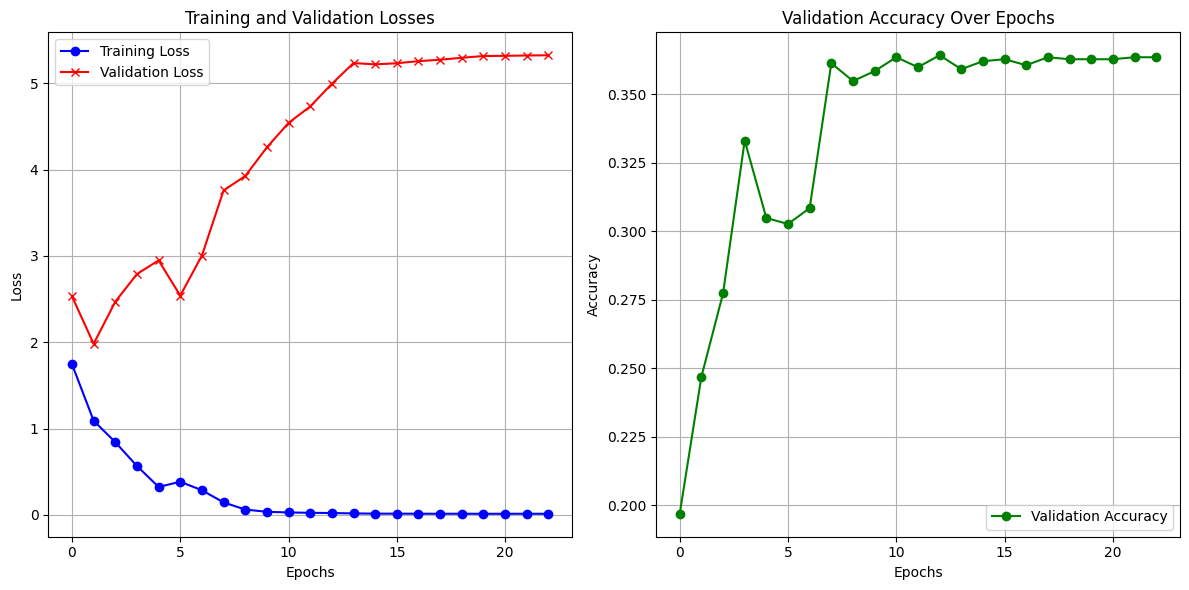

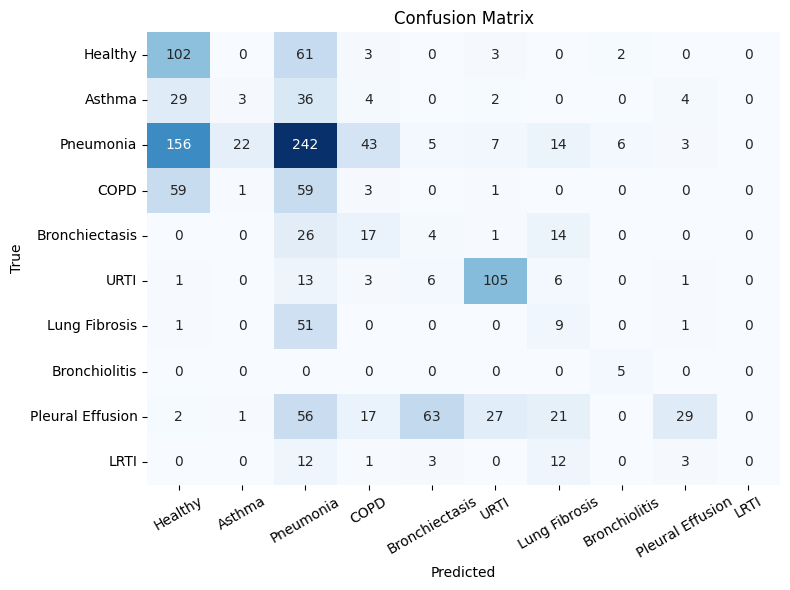

Accuracy: 0.522
Precision: 0.4356
Recall: 0.6321
F1 Score: 0.4552

Test Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.35      0.47      0.40       177
          Asthma       0.17      1.00      0.29         5
       Pneumonia       0.54      0.66      0.59       434
            COPD       0.73      0.25      0.37       279
  Bronchiectasis       0.45      1.00      0.62         5
            URTI       0.84      0.89      0.87       186
   Lung Fibrosis       0.03      0.03      0.03        31
   Bronchiolitis       0.22      1.00      0.36         5
Pleural Effusion       0.03      0.01      0.02        78
            LRTI       1.00      1.00      1.00         5

        accuracy                           0.52      1205
       macro avg       0.44      0.63      0.46      1205
    weighted avg       0.55      0.52      0.50      1205



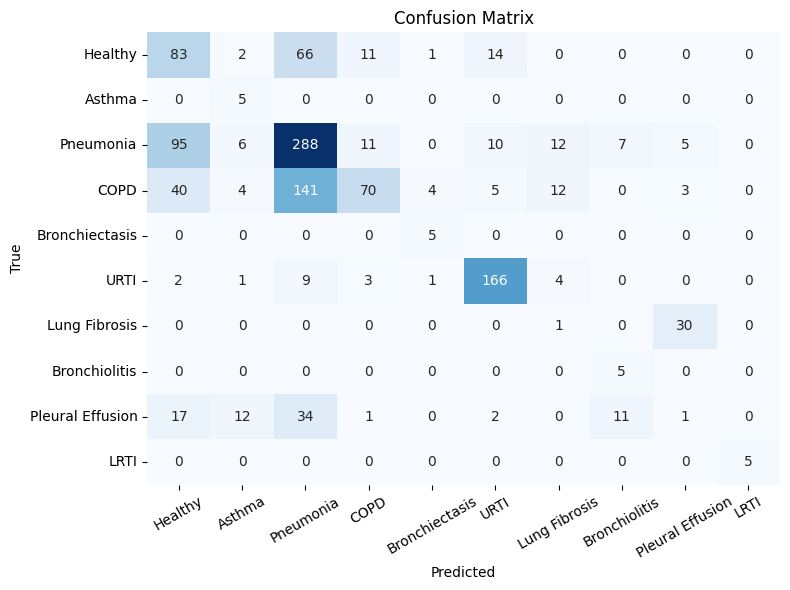

Test Accuracy for CustomCNN: 0.5219917012448133
F1 Score for CustomCNN: 0.4552017333855794


In [ ]:

# Train and evaluate CustomCNN
print("\nTraining CustomCNN...")
custom_cnn_model = CustomCNN(num_classes=10).to(device)

# Define the optimizer with weight decay

optimizer = optim.SGD(custom_cnn_model.parameters(), lr=5e-3, weight_decay=1e-4, momentum=0.9)



# Use ReduceLROnPlateau scheduler instead of StepLR for patience-based learning rate adjustments
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.1)

# Use CrossEntropyLoss with class weights
criterion = nn.CrossEntropyLoss(weight=weights_tensor)

train_model(custom_cnn_model, train_loader, val_loader, criterion, optimizer, scheduler=scheduler, num_epochs=num_epochs, patience=patience,class_names=class_names)

test_acc_customcnn,f1_customcnn = evaluate_model(custom_cnn_model, test_loader, device, class_names)
print(f"Test Accuracy for CustomCNN: {test_acc_customcnn}")
print(f"F1 Score for CustomCNN: {f1_customcnn}")

###ResNet50

In [ ]:
model_resnet50 = PretrainedModel('resnet50', num_classes=10,input_channels=3).to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 206MB/s]



Training ResNet50...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 1 Training Metrics ---
Train Loss: 1.1119, Train Accuracy: 0.4735, Train F1 Score: 0.4412

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.49      0.74      0.59      2299
          Asthma       0.14      0.01      0.03       342
       Pneumonia       0.68      0.18      0.28      3198
            COPD       0.61      0.54      0.57      1225
  Bronchiectasis       0.21      0.87      0.34       341
            URTI       0.71      0.86      0.78      1009
   Lung Fibrosis       0.30      0.16      0.21       620
   Bronchiolitis       0.18      0.45      0.26       261
Pleural Effusion       0.40      0.64      0.49       456
            LRTI       0.25      0.39      0.30        31

        accuracy                           0.47      9782
       macro avg       0.40      0.48      0.39      9782
    weighted avg       0.54      0.47      0.44      9782



Epoch 1/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 1 Validation Metrics ---
Validation Loss: 3.9078, Validation Accuracy: 0.2657, Validation F1 Score: 0.2158

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.22      0.84      0.35       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.60      0.11      0.18       498
            COPD       0.00      0.00      0.00       123
  Bronchiectasis       0.09      0.45      0.15        62
            URTI       0.85      0.79      0.82       135
   Lung Fibrosis       0.35      0.56      0.43        62
   Bronchiolitis       0.00      0.00      0.00         5
Pleural Effusion       0.00      0.00      0.00       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.27      1381
       macro avg       0.21      0.28      0.19      1381
    weighted avg       0.35      0.27      0.22      1381


Improvement detected in validat

Epoch 2/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 2 Training Metrics ---
Train Loss: 0.5812, Train Accuracy: 0.6604, Train F1 Score: 0.6415

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.60      0.85      0.70      2299
          Asthma       0.59      0.03      0.06       342
       Pneumonia       0.80      0.44      0.56      3198
            COPD       0.78      0.79      0.78      1225
  Bronchiectasis       0.43      0.95      0.60       341
            URTI       0.83      0.92      0.87      1009
   Lung Fibrosis       0.57      0.45      0.50       620
   Bronchiolitis       0.40      0.69      0.51       261
Pleural Effusion       0.65      0.87      0.74       456
            LRTI       0.34      0.68      0.45        31

        accuracy                           0.66      9782
       macro avg       0.60      0.67      0.58      9782
    weighted avg       0.70      0.66      0.64      9782



Epoch 2/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 2 Validation Metrics ---
Validation Loss: 2.7463, Validation Accuracy: 0.3534, Validation F1 Score: 0.3490

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.23      0.80      0.36       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.59      0.19      0.29       498
            COPD       0.03      0.02      0.02       123
  Bronchiectasis       0.12      0.39      0.18        62
            URTI       0.79      0.75      0.77       135
   Lung Fibrosis       0.37      0.42      0.39        62
   Bronchiolitis       0.07      0.60      0.13         5
Pleural Effusion       0.93      0.46      0.62       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.35      1381
       macro avg       0.31      0.36      0.28      1381
    weighted avg       0.49      0.35      0.35      1381


Improvement detected in validat

Epoch 3/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 3 Training Metrics ---
Train Loss: 0.3514, Train Accuracy: 0.7686, Train F1 Score: 0.7571

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.69      0.90      0.78      2299
          Asthma       0.80      0.12      0.21       342
       Pneumonia       0.84      0.62      0.71      3198
            COPD       0.87      0.87      0.87      1225
  Bronchiectasis       0.63      0.98      0.77       341
            URTI       0.89      0.95      0.92      1009
   Lung Fibrosis       0.71      0.65      0.68       620
   Bronchiolitis       0.55      0.86      0.67       261
Pleural Effusion       0.77      0.92      0.83       456
            LRTI       0.55      0.84      0.67        31

        accuracy                           0.77      9782
       macro avg       0.73      0.77      0.71      9782
    weighted avg       0.79      0.77      0.76      9782



Epoch 3/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 3 Validation Metrics ---
Validation Loss: 2.4845, Validation Accuracy: 0.4750, Validation F1 Score: 0.4618

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.26      0.78      0.39       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.61      0.39      0.47       498
            COPD       0.11      0.03      0.05       123
  Bronchiectasis       0.23      0.18      0.20        62
            URTI       0.80      0.90      0.84       135
   Lung Fibrosis       0.17      0.21      0.19        62
   Bronchiolitis       0.30      0.60      0.40         5
Pleural Effusion       0.95      0.81      0.88       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.48      1381
       macro avg       0.34      0.39      0.34      1381
    weighted avg       0.51      0.48      0.46      1381


Improvement detected in validat

Epoch 4/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 4 Training Metrics ---
Train Loss: 0.2658, Train Accuracy: 0.8279, Train F1 Score: 0.8211

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.75      0.91      0.82      2299
          Asthma       0.87      0.25      0.38       342
       Pneumonia       0.88      0.72      0.79      3198
            COPD       0.90      0.92      0.91      1225
  Bronchiectasis       0.74      0.99      0.84       341
            URTI       0.91      0.96      0.93      1009
   Lung Fibrosis       0.82      0.82      0.82       620
   Bronchiolitis       0.66      0.89      0.76       261
Pleural Effusion       0.85      0.95      0.90       456
            LRTI       0.78      0.94      0.85        31

        accuracy                           0.83      9782
       macro avg       0.82      0.83      0.80      9782
    weighted avg       0.84      0.83      0.82      9782



Epoch 4/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 4 Validation Metrics ---
Validation Loss: 2.5335, Validation Accuracy: 0.4656, Validation F1 Score: 0.4546

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.28      0.68      0.40       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.55      0.37      0.44       498
            COPD       0.03      0.01      0.01       123
  Bronchiectasis       0.17      0.34      0.23        62
            URTI       0.82      0.84      0.83       135
   Lung Fibrosis       0.34      0.48      0.40        62
   Bronchiolitis       0.23      1.00      0.37         5
Pleural Effusion       0.93      0.80      0.86       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.47      1381
       macro avg       0.33      0.45      0.35      1381
    weighted avg       0.49      0.47      0.45      1381


No improvement in validation ac

Epoch 5/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 5 Training Metrics ---
Train Loss: 0.2020, Train Accuracy: 0.8625, Train F1 Score: 0.8584

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.78      0.94      0.85      2299
          Asthma       0.88      0.39      0.54       342
       Pneumonia       0.91      0.77      0.83      3198
            COPD       0.91      0.92      0.92      1225
  Bronchiectasis       0.81      0.99      0.89       341
            URTI       0.93      0.97      0.95      1009
   Lung Fibrosis       0.84      0.85      0.85       620
   Bronchiolitis       0.81      0.92      0.86       261
Pleural Effusion       0.89      0.97      0.93       456
            LRTI       0.83      0.94      0.88        31

        accuracy                           0.86      9782
       macro avg       0.86      0.87      0.85      9782
    weighted avg       0.87      0.86      0.86      9782



Epoch 5/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 5 Validation Metrics ---
Validation Loss: 3.1658, Validation Accuracy: 0.3707, Validation F1 Score: 0.3634

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.26      0.74      0.39       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.56      0.27      0.36       498
            COPD       0.01      0.01      0.01       123
  Bronchiectasis       0.08      0.10      0.09        62
            URTI       0.82      0.86      0.84       135
   Lung Fibrosis       0.23      0.52      0.32        62
   Bronchiolitis       0.05      0.80      0.09         5
Pleural Effusion       0.70      0.44      0.54       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.37      1381
       macro avg       0.27      0.37      0.26      1381
    weighted avg       0.44      0.37      0.36      1381


No improvement in validation ac

Epoch 6/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 6 Training Metrics ---
Train Loss: 0.1302, Train Accuracy: 0.9092, Train F1 Score: 0.9075

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.85      0.96      0.90      2299
          Asthma       0.89      0.57      0.69       342
       Pneumonia       0.94      0.85      0.89      3198
            COPD       0.95      0.95      0.95      1225
  Bronchiectasis       0.91      1.00      0.95       341
            URTI       0.95      0.98      0.97      1009
   Lung Fibrosis       0.92      0.89      0.90       620
   Bronchiolitis       0.83      0.96      0.89       261
Pleural Effusion       0.94      0.98      0.96       456
            LRTI       0.84      1.00      0.91        31

        accuracy                           0.91      9782
       macro avg       0.90      0.91      0.90      9782
    weighted avg       0.91      0.91      0.91      9782



Epoch 6/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 6 Validation Metrics ---
Validation Loss: 3.9252, Validation Accuracy: 0.4106, Validation F1 Score: 0.3658

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.24      0.89      0.37       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.53      0.15      0.24       498
            COPD       0.00      0.00      0.00       123
  Bronchiectasis       0.23      0.11      0.15        62
            URTI       0.85      0.79      0.82       135
   Lung Fibrosis       0.25      0.40      0.30        62
   Bronchiolitis       0.29      1.00      0.45         5
Pleural Effusion       0.79      0.90      0.84       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.41      1381
       macro avg       0.32      0.43      0.32      1381
    weighted avg       0.45      0.41      0.37      1381


No improvement in validation ac

Epoch 7/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 7 Training Metrics ---
Train Loss: 0.2756, Train Accuracy: 0.8409, Train F1 Score: 0.8388

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.80      0.93      0.86      2299
          Asthma       0.90      0.46      0.61       342
       Pneumonia       0.90      0.73      0.81      3198
            COPD       0.89      0.90      0.90      1225
  Bronchiectasis       0.56      0.96      0.71       341
            URTI       0.91      0.95      0.93      1009
   Lung Fibrosis       0.83      0.81      0.82       620
   Bronchiolitis       0.76      0.92      0.83       261
Pleural Effusion       0.86      0.96      0.91       456
            LRTI       0.67      0.90      0.77        31

        accuracy                           0.84      9782
       macro avg       0.81      0.85      0.81      9782
    weighted avg       0.85      0.84      0.84      9782



Epoch 7/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 7 Validation Metrics ---
Validation Loss: 2.9747, Validation Accuracy: 0.4461, Validation F1 Score: 0.4364

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.25      0.64      0.36       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.53      0.42      0.47       498
            COPD       0.03      0.01      0.01       123
  Bronchiectasis       0.07      0.08      0.08        62
            URTI       0.81      0.86      0.83       135
   Lung Fibrosis       0.16      0.26      0.20        62
   Bronchiolitis       0.28      1.00      0.43         5
Pleural Effusion       0.92      0.70      0.80       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.45      1381
       macro avg       0.31      0.40      0.32      1381
    weighted avg       0.46      0.45      0.44      1381


No improvement in validation ac

Epoch 8/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 8 Training Metrics ---
Train Loss: 0.1250, Train Accuracy: 0.9202, Train F1 Score: 0.9192

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.87      0.96      0.92      2299
          Asthma       0.95      0.68      0.80       342
       Pneumonia       0.95      0.86      0.91      3198
            COPD       0.94      0.96      0.95      1225
  Bronchiectasis       0.84      1.00      0.91       341
            URTI       0.95      0.97      0.96      1009
   Lung Fibrosis       0.92      0.90      0.91       620
   Bronchiolitis       0.91      0.98      0.94       261
Pleural Effusion       0.92      0.98      0.95       456
            LRTI       0.88      0.97      0.92        31

        accuracy                           0.92      9782
       macro avg       0.91      0.93      0.92      9782
    weighted avg       0.92      0.92      0.92      9782



Epoch 8/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 8 Validation Metrics ---
Validation Loss: 3.1852, Validation Accuracy: 0.4077, Validation F1 Score: 0.3889

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.30      0.76      0.43       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.54      0.46      0.50       498
            COPD       0.06      0.02      0.03       123
  Bronchiectasis       0.07      0.11      0.09        62
            URTI       0.71      0.84      0.77       135
   Lung Fibrosis       0.04      0.06      0.05        62
   Bronchiolitis       1.00      0.40      0.57         5
Pleural Effusion       0.68      0.34      0.45       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.41      1381
       macro avg       0.34      0.30      0.29      1381
    weighted avg       0.42      0.41      0.39      1381


No improvement in validation ac

Epoch 9/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 9 Training Metrics ---
Train Loss: 0.1243, Train Accuracy: 0.9219, Train F1 Score: 0.9209

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.89      0.97      0.93      2299
          Asthma       0.93      0.68      0.79       342
       Pneumonia       0.95      0.87      0.91      3198
            COPD       0.94      0.96      0.95      1225
  Bronchiectasis       0.84      0.98      0.90       341
            URTI       0.96      0.98      0.97      1009
   Lung Fibrosis       0.91      0.89      0.90       620
   Bronchiolitis       0.86      0.98      0.92       261
Pleural Effusion       0.92      0.98      0.95       456
            LRTI       0.86      1.00      0.93        31

        accuracy                           0.92      9782
       macro avg       0.91      0.93      0.91      9782
    weighted avg       0.92      0.92      0.92      9782



Epoch 9/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 9 Validation Metrics ---
Validation Loss: 2.6352, Validation Accuracy: 0.4946, Validation F1 Score: 0.4767

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.31      0.63      0.41       171
          Asthma       0.02      0.01      0.02        78
       Pneumonia       0.60      0.54      0.57       498
            COPD       0.00      0.00      0.00       123
  Bronchiectasis       0.13      0.11      0.12        62
            URTI       0.64      0.86      0.74       135
   Lung Fibrosis       0.30      0.52      0.38        62
   Bronchiolitis       0.56      1.00      0.71         5
Pleural Effusion       0.93      0.68      0.78       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.49      1381
       macro avg       0.35      0.43      0.37      1381
    weighted avg       0.49      0.49      0.48      1381


Improvement detected in validat

Epoch 10/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 10 Training Metrics ---
Train Loss: 0.0494, Train Accuracy: 0.9602, Train F1 Score: 0.9596

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.93      0.99      0.96      2299
          Asthma       0.93      0.74      0.83       342
       Pneumonia       0.98      0.93      0.95      3198
            COPD       0.98      0.99      0.99      1225
  Bronchiectasis       0.95      0.99      0.97       341
            URTI       0.96      1.00      0.98      1009
   Lung Fibrosis       0.96      0.95      0.95       620
   Bronchiolitis       0.97      1.00      0.98       261
Pleural Effusion       0.96      0.98      0.97       456
            LRTI       1.00      1.00      1.00        31

        accuracy                           0.96      9782
       macro avg       0.96      0.96      0.96      9782
    weighted avg       0.96      0.96      0.96      9782



Epoch 10/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 10 Validation Metrics ---
Validation Loss: 3.0646, Validation Accuracy: 0.5373, Validation F1 Score: 0.5166

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.31      0.64      0.41       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.62      0.59      0.61       498
            COPD       0.00      0.00      0.00       123
  Bronchiectasis       0.22      0.19      0.21        62
            URTI       0.80      0.84      0.82       135
   Lung Fibrosis       0.27      0.44      0.33        62
   Bronchiolitis       0.62      1.00      0.77         5
Pleural Effusion       0.96      0.83      0.89       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.54      1381
       macro avg       0.38      0.45      0.40      1381
    weighted avg       0.51      0.54      0.52      1381


Improvement detected in valida

Epoch 11/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 11 Training Metrics ---
Train Loss: 0.0350, Train Accuracy: 0.9761, Train F1 Score: 0.9759

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.95      0.99      0.97      2299
          Asthma       0.98      0.85      0.91       342
       Pneumonia       0.98      0.96      0.97      3198
            COPD       0.99      1.00      0.99      1225
  Bronchiectasis       0.96      1.00      0.98       341
            URTI       0.99      1.00      0.99      1009
   Lung Fibrosis       0.99      0.98      0.98       620
   Bronchiolitis       0.97      1.00      0.98       261
Pleural Effusion       0.99      1.00      0.99       456
            LRTI       0.97      1.00      0.98        31

        accuracy                           0.98      9782
       macro avg       0.98      0.98      0.98      9782
    weighted avg       0.98      0.98      0.98      9782



Epoch 11/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 11 Validation Metrics ---
Validation Loss: 3.0359, Validation Accuracy: 0.5424, Validation F1 Score: 0.5202

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.29      0.68      0.41       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.63      0.57      0.60       498
            COPD       0.00      0.00      0.00       123
  Bronchiectasis       0.24      0.10      0.14        62
            URTI       0.86      0.84      0.85       135
   Lung Fibrosis       0.26      0.45      0.33        62
   Bronchiolitis       0.71      1.00      0.83         5
Pleural Effusion       0.98      0.91      0.94       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.54      1381
       macro avg       0.40      0.45      0.41      1381
    weighted avg       0.52      0.54      0.52      1381


Improvement detected in valida

Epoch 12/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 12 Training Metrics ---
Train Loss: 0.0239, Train Accuracy: 0.9810, Train F1 Score: 0.9809

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.96      0.99      0.97      2299
          Asthma       0.98      0.89      0.93       342
       Pneumonia       0.99      0.97      0.98      3198
            COPD       1.00      1.00      1.00      1225
  Bronchiectasis       0.99      1.00      0.99       341
            URTI       0.99      1.00      1.00      1009
   Lung Fibrosis       0.98      0.98      0.98       620
   Bronchiolitis       0.99      0.99      0.99       261
Pleural Effusion       1.00      1.00      1.00       456
            LRTI       1.00      1.00      1.00        31

        accuracy                           0.98      9782
       macro avg       0.99      0.98      0.98      9782
    weighted avg       0.98      0.98      0.98      9782



Epoch 12/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 12 Validation Metrics ---
Validation Loss: 3.1376, Validation Accuracy: 0.5424, Validation F1 Score: 0.5155

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.32      0.57      0.41       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.59      0.61      0.60       498
            COPD       0.00      0.00      0.00       123
  Bronchiectasis       0.24      0.10      0.14        62
            URTI       0.86      0.84      0.85       135
   Lung Fibrosis       0.23      0.40      0.29        62
   Bronchiolitis       0.33      1.00      0.50         5
Pleural Effusion       0.93      0.91      0.92       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.54      1381
       macro avg       0.35      0.44      0.37      1381
    weighted avg       0.50      0.54      0.52      1381


No improvement in validation a

Epoch 13/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 13 Training Metrics ---
Train Loss: 0.0197, Train Accuracy: 0.9848, Train F1 Score: 0.9847

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.96      0.99      0.98      2299
          Asthma       0.99      0.92      0.95       342
       Pneumonia       0.99      0.97      0.98      3198
            COPD       0.99      1.00      1.00      1225
  Bronchiectasis       0.99      1.00      1.00       341
            URTI       1.00      1.00      1.00      1009
   Lung Fibrosis       0.99      0.99      0.99       620
   Bronchiolitis       0.99      1.00      0.99       261
Pleural Effusion       0.99      1.00      0.99       456
            LRTI       1.00      1.00      1.00        31

        accuracy                           0.98      9782
       macro avg       0.99      0.99      0.99      9782
    weighted avg       0.98      0.98      0.98      9782



Epoch 13/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 13 Validation Metrics ---
Validation Loss: 3.1718, Validation Accuracy: 0.5228, Validation F1 Score: 0.4999

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.28      0.64      0.39       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.60      0.52      0.56       498
            COPD       0.00      0.00      0.00       123
  Bronchiectasis       0.28      0.11      0.16        62
            URTI       0.82      0.86      0.84       135
   Lung Fibrosis       0.23      0.37      0.29        62
   Bronchiolitis       0.56      1.00      0.71         5
Pleural Effusion       0.94      0.94      0.94       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.52      1381
       macro avg       0.37      0.44      0.39      1381
    weighted avg       0.50      0.52      0.50      1381


No improvement in validation a

Epoch 14/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 14 Training Metrics ---
Train Loss: 0.0175, Train Accuracy: 0.9876, Train F1 Score: 0.9876

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.97      1.00      0.98      2299
          Asthma       0.99      0.94      0.96       342
       Pneumonia       0.99      0.97      0.98      3198
            COPD       0.99      1.00      1.00      1225
  Bronchiectasis       0.99      1.00      1.00       341
            URTI       1.00      1.00      1.00      1009
   Lung Fibrosis       0.99      0.99      0.99       620
   Bronchiolitis       1.00      1.00      1.00       261
Pleural Effusion       1.00      1.00      1.00       456
            LRTI       1.00      1.00      1.00        31

        accuracy                           0.99      9782
       macro avg       0.99      0.99      0.99      9782
    weighted avg       0.99      0.99      0.99      9782



Epoch 14/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 14 Validation Metrics ---
Validation Loss: 3.1214, Validation Accuracy: 0.5395, Validation F1 Score: 0.5168

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.31      0.64      0.42       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.60      0.57      0.58       498
            COPD       0.00      0.00      0.00       123
  Bronchiectasis       0.36      0.13      0.19        62
            URTI       0.88      0.83      0.85       135
   Lung Fibrosis       0.19      0.34      0.25        62
   Bronchiolitis       0.50      1.00      0.67         5
Pleural Effusion       0.96      0.95      0.95       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.54      1381
       macro avg       0.38      0.45      0.39      1381
    weighted avg       0.52      0.54      0.52      1381


No improvement in validation a

Epoch 15/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 15 Training Metrics ---
Train Loss: 0.0163, Train Accuracy: 0.9866, Train F1 Score: 0.9866

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.97      0.99      0.98      2299
          Asthma       0.98      0.96      0.97       342
       Pneumonia       0.99      0.97      0.98      3198
            COPD       1.00      1.00      1.00      1225
  Bronchiectasis       0.99      1.00      1.00       341
            URTI       0.99      1.00      1.00      1009
   Lung Fibrosis       0.98      0.99      0.99       620
   Bronchiolitis       0.99      1.00      0.99       261
Pleural Effusion       1.00      1.00      1.00       456
            LRTI       1.00      1.00      1.00        31

        accuracy                           0.99      9782
       macro avg       0.99      0.99      0.99      9782
    weighted avg       0.99      0.99      0.99      9782



Epoch 15/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 15 Validation Metrics ---
Validation Loss: 3.2694, Validation Accuracy: 0.5062, Validation F1 Score: 0.4913

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.27      0.66      0.38       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.61      0.49      0.55       498
            COPD       0.00      0.00      0.00       123
  Bronchiectasis       0.22      0.08      0.12        62
            URTI       0.82      0.84      0.83       135
   Lung Fibrosis       0.24      0.40      0.30        62
   Bronchiolitis       0.28      1.00      0.43         5
Pleural Effusion       0.97      0.89      0.93       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.51      1381
       macro avg       0.34      0.44      0.35      1381
    weighted avg       0.51      0.51      0.49      1381


No improvement in validation a

Epoch 16/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 16 Training Metrics ---
Train Loss: 0.0113, Train Accuracy: 0.9908, Train F1 Score: 0.9908

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.98      1.00      0.99      2299
          Asthma       0.99      0.97      0.98       342
       Pneumonia       0.99      0.98      0.99      3198
            COPD       1.00      1.00      1.00      1225
  Bronchiectasis       1.00      1.00      1.00       341
            URTI       1.00      1.00      1.00      1009
   Lung Fibrosis       1.00      1.00      1.00       620
   Bronchiolitis       1.00      1.00      1.00       261
Pleural Effusion       1.00      1.00      1.00       456
            LRTI       1.00      1.00      1.00        31

        accuracy                           0.99      9782
       macro avg       1.00      0.99      0.99      9782
    weighted avg       0.99      0.99      0.99      9782



Epoch 16/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 16 Validation Metrics ---
Validation Loss: 3.3575, Validation Accuracy: 0.5257, Validation F1 Score: 0.5034

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.28      0.64      0.39       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.60      0.54      0.57       498
            COPD       0.00      0.00      0.00       123
  Bronchiectasis       0.31      0.06      0.11        62
            URTI       0.85      0.83      0.84       135
   Lung Fibrosis       0.26      0.45      0.33        62
   Bronchiolitis       0.33      1.00      0.50         5
Pleural Effusion       0.96      0.91      0.93       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.53      1381
       macro avg       0.36      0.44      0.37      1381
    weighted avg       0.51      0.53      0.50      1381


No improvement in validation a

Epoch 17/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 17 Training Metrics ---
Train Loss: 0.0123, Train Accuracy: 0.9886, Train F1 Score: 0.9886

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.97      1.00      0.98      2299
          Asthma       1.00      0.95      0.97       342
       Pneumonia       0.99      0.98      0.98      3198
            COPD       1.00      1.00      1.00      1225
  Bronchiectasis       0.99      1.00      1.00       341
            URTI       1.00      1.00      1.00      1009
   Lung Fibrosis       1.00      0.99      0.99       620
   Bronchiolitis       0.98      1.00      0.99       261
Pleural Effusion       1.00      1.00      1.00       456
            LRTI       1.00      1.00      1.00        31

        accuracy                           0.99      9782
       macro avg       0.99      0.99      0.99      9782
    weighted avg       0.99      0.99      0.99      9782



Epoch 17/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 17 Validation Metrics ---
Validation Loss: 3.1080, Validation Accuracy: 0.5503, Validation F1 Score: 0.5231

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.33      0.58      0.42       171
          Asthma       0.08      0.03      0.04        78
       Pneumonia       0.59      0.64      0.61       498
            COPD       0.00      0.00      0.00       123
  Bronchiectasis       0.28      0.08      0.12        62
            URTI       0.84      0.84      0.84       135
   Lung Fibrosis       0.20      0.32      0.25        62
   Bronchiolitis       0.31      1.00      0.48         5
Pleural Effusion       0.97      0.92      0.94       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.55      1381
       macro avg       0.36      0.44      0.37      1381
    weighted avg       0.51      0.55      0.52      1381


Improvement detected in valida

Epoch 18/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 18 Training Metrics ---
Train Loss: 0.0116, Train Accuracy: 0.9901, Train F1 Score: 0.9901

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.97      1.00      0.99      2299
          Asthma       0.99      0.97      0.98       342
       Pneumonia       0.99      0.98      0.99      3198
            COPD       1.00      1.00      1.00      1225
  Bronchiectasis       0.99      1.00      1.00       341
            URTI       1.00      1.00      1.00      1009
   Lung Fibrosis       1.00      1.00      1.00       620
   Bronchiolitis       1.00      1.00      1.00       261
Pleural Effusion       1.00      1.00      1.00       456
            LRTI       1.00      1.00      1.00        31

        accuracy                           0.99      9782
       macro avg       0.99      0.99      0.99      9782
    weighted avg       0.99      0.99      0.99      9782



Epoch 18/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 18 Validation Metrics ---
Validation Loss: 3.0870, Validation Accuracy: 0.5561, Validation F1 Score: 0.5252

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.35      0.57      0.43       171
          Asthma       0.04      0.01      0.02        78
       Pneumonia       0.58      0.66      0.62       498
            COPD       0.00      0.00      0.00       123
  Bronchiectasis       0.28      0.08      0.12        62
            URTI       0.81      0.84      0.83       135
   Lung Fibrosis       0.22      0.34      0.27        62
   Bronchiolitis       0.36      1.00      0.53         5
Pleural Effusion       0.97      0.90      0.93       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.56      1381
       macro avg       0.36      0.44      0.38      1381
    weighted avg       0.51      0.56      0.53      1381


Improvement detected in valida

Epoch 19/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 19 Training Metrics ---
Train Loss: 0.0109, Train Accuracy: 0.9905, Train F1 Score: 0.9905

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.97      1.00      0.99      2299
          Asthma       1.00      0.96      0.98       342
       Pneumonia       1.00      0.98      0.99      3198
            COPD       1.00      1.00      1.00      1225
  Bronchiectasis       1.00      1.00      1.00       341
            URTI       1.00      1.00      1.00      1009
   Lung Fibrosis       1.00      1.00      1.00       620
   Bronchiolitis       0.99      1.00      0.99       261
Pleural Effusion       1.00      1.00      1.00       456
            LRTI       1.00      1.00      1.00        31

        accuracy                           0.99      9782
       macro avg       0.99      0.99      0.99      9782
    weighted avg       0.99      0.99      0.99      9782



Epoch 19/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 19 Validation Metrics ---
Validation Loss: 3.2425, Validation Accuracy: 0.5141, Validation F1 Score: 0.4936

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.28      0.65      0.39       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.60      0.53      0.57       498
            COPD       0.00      0.00      0.00       123
  Bronchiectasis       0.24      0.08      0.12        62
            URTI       0.81      0.84      0.83       135
   Lung Fibrosis       0.16      0.24      0.19        62
   Bronchiolitis       0.36      1.00      0.53         5
Pleural Effusion       0.95      0.90      0.92       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.51      1381
       macro avg       0.34      0.43      0.35      1381
    weighted avg       0.50      0.51      0.49      1381


No improvement in validation a

Epoch 20/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 20 Training Metrics ---
Train Loss: 0.0111, Train Accuracy: 0.9907, Train F1 Score: 0.9907

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.97      1.00      0.98      2299
          Asthma       0.99      0.96      0.98       342
       Pneumonia       0.99      0.98      0.99      3198
            COPD       1.00      1.00      1.00      1225
  Bronchiectasis       1.00      1.00      1.00       341
            URTI       1.00      1.00      1.00      1009
   Lung Fibrosis       1.00      1.00      1.00       620
   Bronchiolitis       1.00      1.00      1.00       261
Pleural Effusion       1.00      1.00      1.00       456
            LRTI       1.00      0.97      0.98        31

        accuracy                           0.99      9782
       macro avg       1.00      0.99      0.99      9782
    weighted avg       0.99      0.99      0.99      9782



Epoch 20/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 20 Validation Metrics ---
Validation Loss: 3.1932, Validation Accuracy: 0.5380, Validation F1 Score: 0.5121

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.31      0.60      0.41       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.58      0.60      0.59       498
            COPD       0.00      0.00      0.00       123
  Bronchiectasis       0.29      0.10      0.14        62
            URTI       0.84      0.84      0.84       135
   Lung Fibrosis       0.20      0.31      0.24        62
   Bronchiolitis       0.29      1.00      0.45         5
Pleural Effusion       0.98      0.91      0.94       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.54      1381
       macro avg       0.35      0.44      0.36      1381
    weighted avg       0.50      0.54      0.51      1381


No improvement in validation a

Epoch 21/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 21 Training Metrics ---
Train Loss: 0.0115, Train Accuracy: 0.9914, Train F1 Score: 0.9914

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.97      1.00      0.99      2299
          Asthma       0.99      0.97      0.98       342
       Pneumonia       1.00      0.98      0.99      3198
            COPD       1.00      1.00      1.00      1225
  Bronchiectasis       1.00      1.00      1.00       341
            URTI       1.00      1.00      1.00      1009
   Lung Fibrosis       1.00      1.00      1.00       620
   Bronchiolitis       1.00      1.00      1.00       261
Pleural Effusion       1.00      1.00      1.00       456
            LRTI       1.00      1.00      1.00        31

        accuracy                           0.99      9782
       macro avg       1.00      0.99      0.99      9782
    weighted avg       0.99      0.99      0.99      9782



Epoch 21/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 21 Validation Metrics ---
Validation Loss: 3.1062, Validation Accuracy: 0.5358, Validation F1 Score: 0.5131

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.31      0.59      0.40       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.59      0.60      0.60       498
            COPD       0.00      0.00      0.00       123
  Bronchiectasis       0.25      0.10      0.14        62
            URTI       0.86      0.83      0.85       135
   Lung Fibrosis       0.18      0.32      0.23        62
   Bronchiolitis       0.45      1.00      0.62         5
Pleural Effusion       0.96      0.92      0.94       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.54      1381
       macro avg       0.36      0.44      0.38      1381
    weighted avg       0.51      0.54      0.51      1381


No improvement in validation a

Epoch 22/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 22 Training Metrics ---
Train Loss: 0.0116, Train Accuracy: 0.9917, Train F1 Score: 0.9917

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.97      1.00      0.99      2299
          Asthma       1.00      0.97      0.98       342
       Pneumonia       1.00      0.98      0.99      3198
            COPD       1.00      1.00      1.00      1225
  Bronchiectasis       1.00      1.00      1.00       341
            URTI       1.00      1.00      1.00      1009
   Lung Fibrosis       1.00      1.00      1.00       620
   Bronchiolitis       1.00      1.00      1.00       261
Pleural Effusion       1.00      1.00      1.00       456
            LRTI       1.00      1.00      1.00        31

        accuracy                           0.99      9782
       macro avg       1.00      0.99      0.99      9782
    weighted avg       0.99      0.99      0.99      9782



Epoch 22/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 22 Validation Metrics ---
Validation Loss: 3.1898, Validation Accuracy: 0.5243, Validation F1 Score: 0.5049

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.31      0.61      0.41       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.60      0.56      0.58       498
            COPD       0.00      0.00      0.00       123
  Bronchiectasis       0.27      0.10      0.14        62
            URTI       0.80      0.84      0.82       135
   Lung Fibrosis       0.17      0.31      0.22        62
   Bronchiolitis       0.28      1.00      0.43         5
Pleural Effusion       0.97      0.90      0.93       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.52      1381
       macro avg       0.34      0.43      0.35      1381
    weighted avg       0.51      0.52      0.50      1381


No improvement in validation a

Epoch 23/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 23 Training Metrics ---
Train Loss: 0.0098, Train Accuracy: 0.9921, Train F1 Score: 0.9921

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.97      1.00      0.99      2299
          Asthma       1.00      0.96      0.98       342
       Pneumonia       1.00      0.98      0.99      3198
            COPD       1.00      1.00      1.00      1225
  Bronchiectasis       1.00      1.00      1.00       341
            URTI       1.00      1.00      1.00      1009
   Lung Fibrosis       1.00      1.00      1.00       620
   Bronchiolitis       1.00      1.00      1.00       261
Pleural Effusion       1.00      1.00      1.00       456
            LRTI       1.00      1.00      1.00        31

        accuracy                           0.99      9782
       macro avg       1.00      0.99      1.00      9782
    weighted avg       0.99      0.99      0.99      9782



Epoch 23/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 23 Validation Metrics ---
Validation Loss: 3.2060, Validation Accuracy: 0.5250, Validation F1 Score: 0.5036

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.30      0.64      0.40       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.60      0.56      0.58       498
            COPD       0.00      0.00      0.00       123
  Bronchiectasis       0.27      0.10      0.14        62
            URTI       0.81      0.84      0.82       135
   Lung Fibrosis       0.19      0.35      0.25        62
   Bronchiolitis       0.42      1.00      0.59         5
Pleural Effusion       0.96      0.89      0.93       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.52      1381
       macro avg       0.35      0.44      0.37      1381
    weighted avg       0.51      0.52      0.50      1381


No improvement in validation a

Epoch 24/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 24 Training Metrics ---
Train Loss: 0.0108, Train Accuracy: 0.9903, Train F1 Score: 0.9903

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.97      1.00      0.98      2299
          Asthma       1.00      0.97      0.98       342
       Pneumonia       1.00      0.98      0.99      3198
            COPD       1.00      1.00      1.00      1225
  Bronchiectasis       1.00      1.00      1.00       341
            URTI       1.00      1.00      1.00      1009
   Lung Fibrosis       0.99      1.00      1.00       620
   Bronchiolitis       1.00      1.00      1.00       261
Pleural Effusion       1.00      1.00      1.00       456
            LRTI       1.00      1.00      1.00        31

        accuracy                           0.99      9782
       macro avg       0.99      0.99      0.99      9782
    weighted avg       0.99      0.99      0.99      9782



Epoch 24/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 24 Validation Metrics ---
Validation Loss: 3.2497, Validation Accuracy: 0.5329, Validation F1 Score: 0.5065

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.32      0.59      0.41       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.58      0.63      0.60       498
            COPD       0.00      0.00      0.00       123
  Bronchiectasis       0.25      0.08      0.12        62
            URTI       0.82      0.84      0.83       135
   Lung Fibrosis       0.13      0.19      0.16        62
   Bronchiolitis       0.28      1.00      0.43         5
Pleural Effusion       0.98      0.86      0.92       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.53      1381
       macro avg       0.34      0.42      0.35      1381
    weighted avg       0.50      0.53      0.51      1381


No improvement in validation a

Epoch 25/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 25 Training Metrics ---
Train Loss: 0.0098, Train Accuracy: 0.9916, Train F1 Score: 0.9916

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.98      1.00      0.99      2299
          Asthma       1.00      0.97      0.98       342
       Pneumonia       0.99      0.98      0.99      3198
            COPD       1.00      1.00      1.00      1225
  Bronchiectasis       1.00      1.00      1.00       341
            URTI       1.00      1.00      1.00      1009
   Lung Fibrosis       1.00      1.00      1.00       620
   Bronchiolitis       1.00      1.00      1.00       261
Pleural Effusion       1.00      1.00      1.00       456
            LRTI       0.97      1.00      0.98        31

        accuracy                           0.99      9782
       macro avg       0.99      0.99      0.99      9782
    weighted avg       0.99      0.99      0.99      9782



Epoch 25/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 25 Validation Metrics ---
Validation Loss: 3.2333, Validation Accuracy: 0.5301, Validation F1 Score: 0.5098

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.30      0.60      0.40       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.61      0.58      0.59       498
            COPD       0.00      0.00      0.00       123
  Bronchiectasis       0.26      0.08      0.12        62
            URTI       0.82      0.84      0.83       135
   Lung Fibrosis       0.21      0.44      0.28        62
   Bronchiolitis       0.42      1.00      0.59         5
Pleural Effusion       0.97      0.88      0.92       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.53      1381
       macro avg       0.36      0.44      0.37      1381
    weighted avg       0.51      0.53      0.51      1381


No improvement in validation a

Epoch 26/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 26 Training Metrics ---
Train Loss: 0.0104, Train Accuracy: 0.9919, Train F1 Score: 0.9919

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.97      1.00      0.99      2299
          Asthma       0.99      0.98      0.99       342
       Pneumonia       1.00      0.98      0.99      3198
            COPD       1.00      1.00      1.00      1225
  Bronchiectasis       1.00      1.00      1.00       341
            URTI       1.00      1.00      1.00      1009
   Lung Fibrosis       1.00      0.99      1.00       620
   Bronchiolitis       1.00      1.00      1.00       261
Pleural Effusion       1.00      1.00      1.00       456
            LRTI       1.00      1.00      1.00        31

        accuracy                           0.99      9782
       macro avg       1.00      0.99      1.00      9782
    weighted avg       0.99      0.99      0.99      9782



Epoch 26/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 26 Validation Metrics ---
Validation Loss: 3.3089, Validation Accuracy: 0.5156, Validation F1 Score: 0.4947

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.29      0.65      0.40       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.60      0.55      0.58       498
            COPD       0.00      0.00      0.00       123
  Bronchiectasis       0.23      0.08      0.12        62
            URTI       0.78      0.84      0.81       135
   Lung Fibrosis       0.17      0.26      0.21        62
   Bronchiolitis       0.29      1.00      0.45         5
Pleural Effusion       0.97      0.85      0.91       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.52      1381
       macro avg       0.33      0.42      0.35      1381
    weighted avg       0.50      0.52      0.49      1381


No improvement in validation a

Epoch 27/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 27 Training Metrics ---
Train Loss: 0.0091, Train Accuracy: 0.9916, Train F1 Score: 0.9916

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.97      1.00      0.99      2299
          Asthma       1.00      0.96      0.98       342
       Pneumonia       1.00      0.98      0.99      3198
            COPD       1.00      1.00      1.00      1225
  Bronchiectasis       1.00      1.00      1.00       341
            URTI       1.00      1.00      1.00      1009
   Lung Fibrosis       1.00      1.00      1.00       620
   Bronchiolitis       1.00      1.00      1.00       261
Pleural Effusion       1.00      1.00      1.00       456
            LRTI       1.00      1.00      1.00        31

        accuracy                           0.99      9782
       macro avg       1.00      0.99      0.99      9782
    weighted avg       0.99      0.99      0.99      9782



Epoch 27/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 27 Validation Metrics ---
Validation Loss: 3.0736, Validation Accuracy: 0.5402, Validation F1 Score: 0.5158

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.33      0.59      0.43       171
          Asthma       0.03      0.01      0.02        78
       Pneumonia       0.58      0.62      0.60       498
            COPD       0.00      0.00      0.00       123
  Bronchiectasis       0.23      0.08      0.12        62
            URTI       0.82      0.84      0.83       135
   Lung Fibrosis       0.19      0.29      0.23        62
   Bronchiolitis       0.33      1.00      0.50         5
Pleural Effusion       0.98      0.90      0.94       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.54      1381
       macro avg       0.35      0.43      0.37      1381
    weighted avg       0.51      0.54      0.52      1381


No improvement in validation a

Epoch 28/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 28 Training Metrics ---
Train Loss: 0.0103, Train Accuracy: 0.9921, Train F1 Score: 0.9921

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.97      1.00      0.99      2299
          Asthma       1.00      0.98      0.99       342
       Pneumonia       1.00      0.98      0.99      3198
            COPD       1.00      1.00      1.00      1225
  Bronchiectasis       1.00      1.00      1.00       341
            URTI       1.00      1.00      1.00      1009
   Lung Fibrosis       1.00      1.00      1.00       620
   Bronchiolitis       1.00      1.00      1.00       261
Pleural Effusion       1.00      1.00      1.00       456
            LRTI       1.00      1.00      1.00        31

        accuracy                           0.99      9782
       macro avg       1.00      1.00      1.00      9782
    weighted avg       0.99      0.99      0.99      9782



Epoch 28/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 28 Validation Metrics ---
Validation Loss: 3.3246, Validation Accuracy: 0.5510, Validation F1 Score: 0.5226

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.33      0.57      0.42       171
          Asthma       0.04      0.01      0.02        78
       Pneumonia       0.59      0.64      0.62       498
            COPD       0.00      0.00      0.00       123
  Bronchiectasis       0.35      0.10      0.15        62
            URTI       0.82      0.84      0.83       135
   Lung Fibrosis       0.20      0.37      0.26        62
   Bronchiolitis       0.36      1.00      0.53         5
Pleural Effusion       0.96      0.91      0.93       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.55      1381
       macro avg       0.37      0.44      0.38      1381
    weighted avg       0.51      0.55      0.52      1381


No improvement in validation a

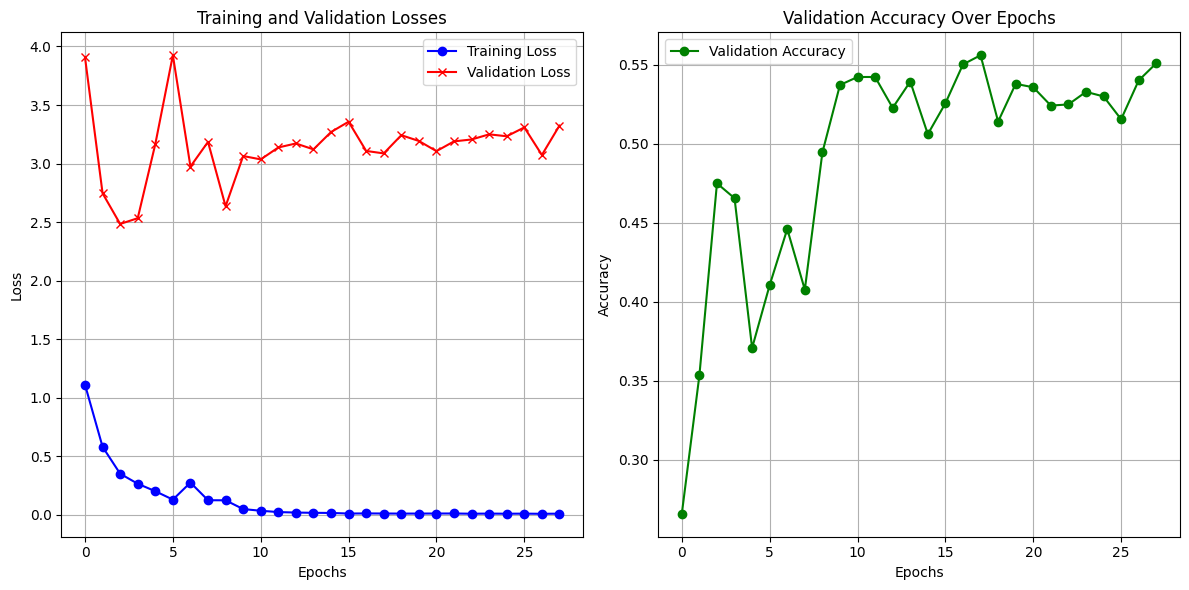

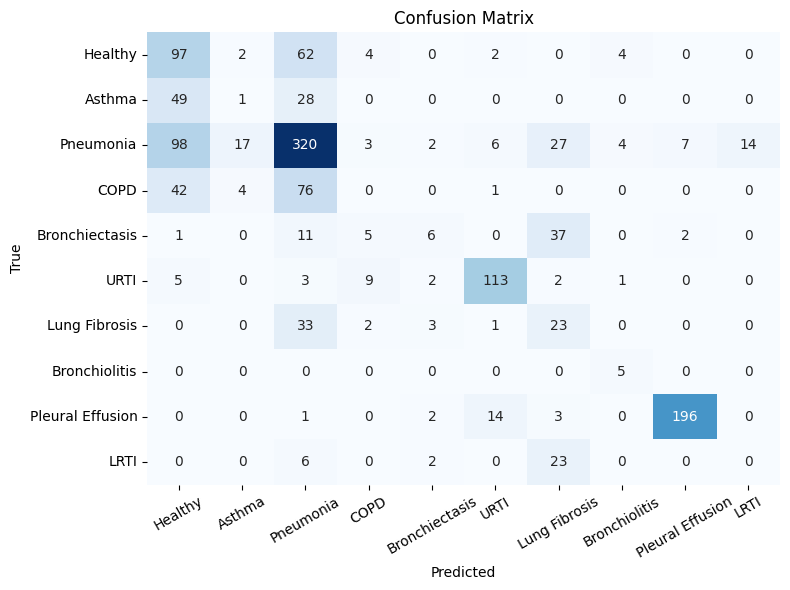

Accuracy: 0.7436
Precision: 0.6702
Recall: 0.7233
F1 Score: 0.6748

Test Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.54      0.76      0.63       177
          Asthma       0.22      0.80      0.35         5
       Pneumonia       0.74      0.79      0.77       434
            COPD       0.98      0.66      0.79       279
  Bronchiectasis       1.00      1.00      1.00         5
            URTI       0.90      0.97      0.93       186
   Lung Fibrosis       0.00      0.00      0.00        31
   Bronchiolitis       0.80      0.80      0.80         5
Pleural Effusion       0.51      0.45      0.48        78
            LRTI       1.00      1.00      1.00         5

        accuracy                           0.74      1205
       macro avg       0.67      0.72      0.67      1205
    weighted avg       0.76      0.74      0.74      1205



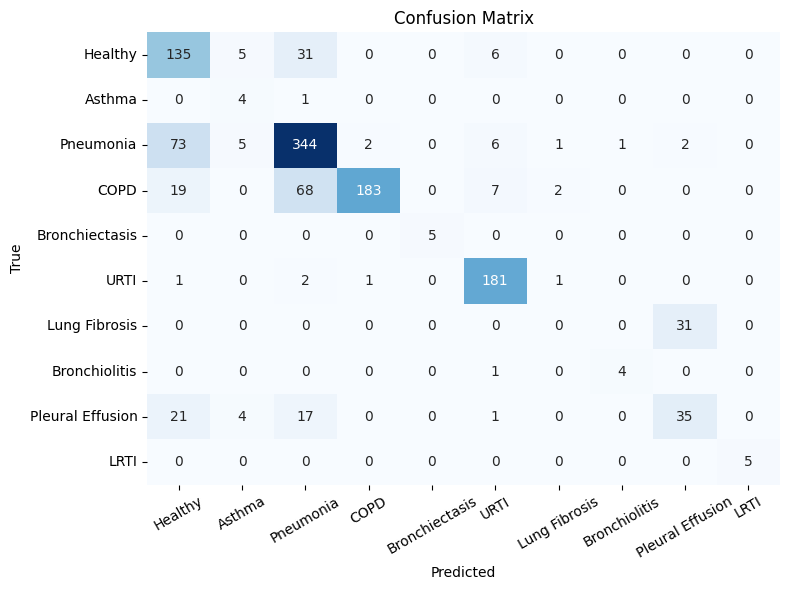

Test Accuracy for ResNet50: 0.7435684647302905
F1 Score for ResNet50: 0.674816853839485


In [ ]:

# Train and evaluate ResNet50
print("\nTraining ResNet50...")
model_resnet50 = PretrainedModel('resnet50', num_classes=10,input_channels=3).to(device)
optimizer_resnet50 = optim.AdamW(model_resnet50.parameters(), lr=5e-5, weight_decay=1e-5)
scheduler_resnet50 = ReduceLROnPlateau(optimizer_resnet50, mode='min', patience=5, factor=0.1)
criterion_resnet50 = nn.CrossEntropyLoss(weight=weights_tensor)

train_model(model_resnet50, train_loader, val_loader, criterion_resnet50, optimizer_resnet50, scheduler=scheduler_resnet50, num_epochs=num_epochs, patience=patience,class_names=class_names)
test_acc_resnet50,f1_resnet50 = evaluate_model(model_resnet50, test_loader,device, class_names)
print(f"Test Accuracy for ResNet50: {test_acc_resnet50}")
print(f"F1 Score for ResNet50: {f1_resnet50}")

###DenseNet16


Training DenseNet121...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 155MB/s]


Epoch 1/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 1 Training Metrics ---
Train Loss: 1.0891, Train Accuracy: 0.4450, Train F1 Score: 0.4090

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.47      0.73      0.57      2299
          Asthma       0.01      0.00      0.00       342
       Pneumonia       0.64      0.14      0.23      3198
            COPD       0.60      0.50      0.54      1225
  Bronchiectasis       0.21      0.88      0.34       341
            URTI       0.70      0.84      0.77      1009
   Lung Fibrosis       0.27      0.16      0.20       620
   Bronchiolitis       0.16      0.34      0.22       261
Pleural Effusion       0.41      0.57      0.48       456
            LRTI       0.08      0.32      0.12        31

        accuracy                           0.45      9782
       macro avg       0.35      0.45      0.35      9782
    weighted avg       0.51      0.45      0.41      9782



Epoch 1/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 1 Validation Metrics ---
Validation Loss: 2.1934, Validation Accuracy: 0.3497, Validation F1 Score: 0.3290

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.21      0.78      0.33       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.63      0.14      0.23       498
            COPD       0.00      0.00      0.00       123
  Bronchiectasis       0.18      0.66      0.28        62
            URTI       0.82      0.85      0.84       135
   Lung Fibrosis       0.23      0.21      0.22        62
   Bronchiolitis       0.03      0.20      0.05         5
Pleural Effusion       0.89      0.50      0.64       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.35      1381
       macro avg       0.30      0.33      0.26      1381
    weighted avg       0.49      0.35      0.33      1381


Improvement detected in validat

Epoch 2/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 2 Training Metrics ---
Train Loss: 0.5618, Train Accuracy: 0.6523, Train F1 Score: 0.6313

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.59      0.87      0.70      2299
          Asthma       0.60      0.01      0.02       342
       Pneumonia       0.77      0.42      0.55      3198
            COPD       0.79      0.73      0.76      1225
  Bronchiectasis       0.43      0.97      0.59       341
            URTI       0.84      0.94      0.88      1009
   Lung Fibrosis       0.52      0.43      0.47       620
   Bronchiolitis       0.38      0.64      0.48       261
Pleural Effusion       0.66      0.86      0.75       456
            LRTI       0.38      0.65      0.48        31

        accuracy                           0.65      9782
       macro avg       0.60      0.65      0.57      9782
    weighted avg       0.69      0.65      0.63      9782



Epoch 2/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 2 Validation Metrics ---
Validation Loss: 2.1134, Validation Accuracy: 0.4424, Validation F1 Score: 0.4235

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.25      0.81      0.38       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.58      0.27      0.37       498
            COPD       0.00      0.00      0.00       123
  Bronchiectasis       0.31      0.63      0.42        62
            URTI       0.82      0.88      0.85       135
   Lung Fibrosis       0.09      0.08      0.09        62
   Bronchiolitis       0.08      0.40      0.13         5
Pleural Effusion       0.95      0.80      0.87       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.44      1381
       macro avg       0.31      0.39      0.31      1381
    weighted avg       0.49      0.44      0.42      1381


Improvement detected in validat

Epoch 3/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 3 Training Metrics ---
Train Loss: 0.3909, Train Accuracy: 0.7501, Train F1 Score: 0.7355

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.68      0.89      0.77      2299
          Asthma       0.82      0.03      0.05       342
       Pneumonia       0.83      0.60      0.70      3198
            COPD       0.86      0.83      0.84      1225
  Bronchiectasis       0.61      0.98      0.75       341
            URTI       0.88      0.95      0.91      1009
   Lung Fibrosis       0.68      0.66      0.67       620
   Bronchiolitis       0.48      0.77      0.59       261
Pleural Effusion       0.79      0.92      0.85       456
            LRTI       0.56      0.87      0.68        31

        accuracy                           0.75      9782
       macro avg       0.72      0.75      0.68      9782
    weighted avg       0.77      0.75      0.74      9782



Epoch 3/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 3 Validation Metrics ---
Validation Loss: 2.0516, Validation Accuracy: 0.5134, Validation F1 Score: 0.4864

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.28      0.75      0.41       171
          Asthma       0.25      0.01      0.02        78
       Pneumonia       0.59      0.46      0.52       498
            COPD       0.00      0.00      0.00       123
  Bronchiectasis       0.38      0.42      0.40        62
            URTI       0.87      0.80      0.83       135
   Lung Fibrosis       0.06      0.05      0.05        62
   Bronchiolitis       0.25      0.60      0.35         5
Pleural Effusion       0.89      0.97      0.93       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.51      1381
       macro avg       0.36      0.41      0.35      1381
    weighted avg       0.51      0.51      0.49      1381


Improvement detected in validat

Epoch 4/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 4 Training Metrics ---
Train Loss: 0.2749, Train Accuracy: 0.8083, Train F1 Score: 0.7953

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.73      0.93      0.82      2299
          Asthma       0.96      0.07      0.14       342
       Pneumonia       0.87      0.69      0.77      3198
            COPD       0.90      0.90      0.90      1225
  Bronchiectasis       0.76      0.99      0.86       341
            URTI       0.90      0.96      0.93      1009
   Lung Fibrosis       0.73      0.74      0.73       620
   Bronchiolitis       0.63      0.90      0.74       261
Pleural Effusion       0.80      0.93      0.86       456
            LRTI       0.76      0.94      0.84        31

        accuracy                           0.81      9782
       macro avg       0.80      0.80      0.76      9782
    weighted avg       0.82      0.81      0.80      9782



Epoch 4/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 4 Validation Metrics ---
Validation Loss: 2.3567, Validation Accuracy: 0.4931, Validation F1 Score: 0.4738

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.26      0.78      0.39       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.64      0.38      0.47       498
            COPD       0.00      0.00      0.00       123
  Bronchiectasis       0.33      0.29      0.31        62
            URTI       0.85      0.85      0.85       135
   Lung Fibrosis       0.16      0.23      0.19        62
   Bronchiolitis       0.07      0.40      0.12         5
Pleural Effusion       0.93      0.98      0.95       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.49      1381
       macro avg       0.32      0.39      0.33      1381
    weighted avg       0.51      0.49      0.47      1381


No improvement in validation ac

Epoch 5/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 5 Training Metrics ---
Train Loss: 0.2469, Train Accuracy: 0.8325, Train F1 Score: 0.8239

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.77      0.93      0.85      2299
          Asthma       0.92      0.19      0.32       342
       Pneumonia       0.89      0.72      0.80      3198
            COPD       0.91      0.91      0.91      1225
  Bronchiectasis       0.71      0.98      0.82       341
            URTI       0.90      0.96      0.93      1009
   Lung Fibrosis       0.78      0.79      0.78       620
   Bronchiolitis       0.68      0.92      0.78       261
Pleural Effusion       0.85      0.96      0.90       456
            LRTI       0.61      0.90      0.73        31

        accuracy                           0.83      9782
       macro avg       0.80      0.83      0.78      9782
    weighted avg       0.84      0.83      0.82      9782



Epoch 5/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 5 Validation Metrics ---
Validation Loss: 2.6352, Validation Accuracy: 0.3932, Validation F1 Score: 0.3841

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.28      0.55      0.37       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.59      0.29      0.39       498
            COPD       0.04      0.02      0.03       123
  Bronchiectasis       0.31      0.53      0.39        62
            URTI       0.38      0.86      0.53       135
   Lung Fibrosis       0.26      0.32      0.29        62
   Bronchiolitis       0.03      0.40      0.06         5
Pleural Effusion       0.89      0.61      0.72       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.39      1381
       macro avg       0.28      0.36      0.28      1381
    weighted avg       0.45      0.39      0.38      1381


No improvement in validation ac

Epoch 6/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 6 Training Metrics ---
Train Loss: 0.1794, Train Accuracy: 0.8706, Train F1 Score: 0.8646

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.81      0.95      0.88      2299
          Asthma       0.87      0.29      0.44       342
       Pneumonia       0.91      0.79      0.84      3198
            COPD       0.93      0.93      0.93      1225
  Bronchiectasis       0.81      0.99      0.89       341
            URTI       0.93      0.97      0.95      1009
   Lung Fibrosis       0.84      0.86      0.85       620
   Bronchiolitis       0.76      0.94      0.84       261
Pleural Effusion       0.87      0.98      0.92       456
            LRTI       0.84      1.00      0.91        31

        accuracy                           0.87      9782
       macro avg       0.86      0.87      0.85      9782
    weighted avg       0.88      0.87      0.86      9782



Epoch 6/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 6 Validation Metrics ---
Validation Loss: 2.6292, Validation Accuracy: 0.4591, Validation F1 Score: 0.4588

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.25      0.67      0.36       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.62      0.44      0.52       498
            COPD       0.00      0.00      0.00       123
  Bronchiectasis       0.12      0.15      0.13        62
            URTI       0.82      0.84      0.83       135
   Lung Fibrosis       0.20      0.39      0.27        62
   Bronchiolitis       0.15      0.80      0.25         5
Pleural Effusion       0.99      0.69      0.82       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.46      1381
       macro avg       0.32      0.40      0.32      1381
    weighted avg       0.51      0.46      0.46      1381


No improvement in validation ac

Epoch 7/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 7 Training Metrics ---
Train Loss: 0.1495, Train Accuracy: 0.8965, Train F1 Score: 0.8930

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.84      0.95      0.89      2299
          Asthma       0.89      0.41      0.56       342
       Pneumonia       0.93      0.83      0.88      3198
            COPD       0.94      0.95      0.95      1225
  Bronchiectasis       0.87      1.00      0.93       341
            URTI       0.95      0.98      0.96      1009
   Lung Fibrosis       0.90      0.91      0.90       620
   Bronchiolitis       0.78      0.94      0.85       261
Pleural Effusion       0.91      0.98      0.94       456
            LRTI       0.86      1.00      0.93        31

        accuracy                           0.90      9782
       macro avg       0.89      0.89      0.88      9782
    weighted avg       0.90      0.90      0.89      9782



Epoch 7/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 7 Validation Metrics ---
Validation Loss: 2.5151, Validation Accuracy: 0.4953, Validation F1 Score: 0.4826

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.25      0.76      0.37       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.61      0.41      0.49       498
            COPD       0.05      0.01      0.01       123
  Bronchiectasis       0.39      0.48      0.43        62
            URTI       0.88      0.81      0.84       135
   Lung Fibrosis       0.34      0.37      0.35        62
   Bronchiolitis       0.16      0.80      0.27         5
Pleural Effusion       0.95      0.86      0.90       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.50      1381
       macro avg       0.36      0.45      0.37      1381
    weighted avg       0.52      0.50      0.48      1381


No improvement in validation ac

Epoch 8/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 8 Training Metrics ---
Train Loss: 0.1136, Train Accuracy: 0.9183, Train F1 Score: 0.9159

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.87      0.97      0.92      2299
          Asthma       0.94      0.51      0.66       342
       Pneumonia       0.94      0.87      0.90      3198
            COPD       0.95      0.96      0.96      1225
  Bronchiectasis       0.90      1.00      0.94       341
            URTI       0.96      0.98      0.97      1009
   Lung Fibrosis       0.91      0.93      0.92       620
   Bronchiolitis       0.84      0.97      0.90       261
Pleural Effusion       0.96      0.98      0.97       456
            LRTI       0.83      0.97      0.90        31

        accuracy                           0.92      9782
       macro avg       0.91      0.91      0.90      9782
    weighted avg       0.92      0.92      0.92      9782



Epoch 8/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 8 Validation Metrics ---
Validation Loss: 2.7380, Validation Accuracy: 0.5127, Validation F1 Score: 0.4986

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.25      0.78      0.38       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.73      0.40      0.51       498
            COPD       0.00      0.00      0.00       123
  Bronchiectasis       0.34      0.45      0.39        62
            URTI       0.81      0.87      0.84       135
   Lung Fibrosis       0.39      0.47      0.43        62
   Bronchiolitis       0.30      0.60      0.40         5
Pleural Effusion       0.94      0.92      0.93       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.51      1381
       macro avg       0.38      0.45      0.39      1381
    weighted avg       0.56      0.51      0.50      1381


No improvement in validation ac

Epoch 9/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 9 Training Metrics ---
Train Loss: 0.1056, Train Accuracy: 0.9247, Train F1 Score: 0.9231

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.88      0.97      0.92      2299
          Asthma       0.92      0.59      0.72       342
       Pneumonia       0.95      0.87      0.91      3198
            COPD       0.96      0.97      0.96      1225
  Bronchiectasis       0.92      0.99      0.95       341
            URTI       0.96      0.99      0.97      1009
   Lung Fibrosis       0.92      0.92      0.92       620
   Bronchiolitis       0.83      0.95      0.88       261
Pleural Effusion       0.94      0.98      0.96       456
            LRTI       0.88      0.94      0.91        31

        accuracy                           0.92      9782
       macro avg       0.91      0.92      0.91      9782
    weighted avg       0.93      0.92      0.92      9782



Epoch 9/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 9 Validation Metrics ---
Validation Loss: 2.6210, Validation Accuracy: 0.5380, Validation F1 Score: 0.5246

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.27      0.53      0.36       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.64      0.55      0.59       498
            COPD       0.06      0.02      0.03       123
  Bronchiectasis       0.44      0.42      0.43        62
            URTI       0.85      0.87      0.86       135
   Lung Fibrosis       0.23      0.37      0.29        62
   Bronchiolitis       0.27      0.80      0.40         5
Pleural Effusion       0.92      0.95      0.93       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.54      1381
       macro avg       0.37      0.45      0.39      1381
    weighted avg       0.53      0.54      0.52      1381


Improvement detected in validat

Epoch 10/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 10 Training Metrics ---
Train Loss: 0.0512, Train Accuracy: 0.9628, Train F1 Score: 0.9623

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.94      0.99      0.96      2299
          Asthma       0.97      0.77      0.86       342
       Pneumonia       0.98      0.93      0.95      3198
            COPD       0.98      0.99      0.98      1225
  Bronchiectasis       0.95      1.00      0.97       341
            URTI       0.98      0.99      0.99      1009
   Lung Fibrosis       0.95      0.98      0.96       620
   Bronchiolitis       0.95      1.00      0.97       261
Pleural Effusion       0.98      0.99      0.98       456
            LRTI       0.84      1.00      0.91        31

        accuracy                           0.96      9782
       macro avg       0.95      0.96      0.95      9782
    weighted avg       0.96      0.96      0.96      9782



Epoch 10/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 10 Validation Metrics ---
Validation Loss: 2.6904, Validation Accuracy: 0.5185, Validation F1 Score: 0.5099

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.24      0.60      0.35       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.66      0.56      0.60       498
            COPD       0.03      0.01      0.01       123
  Bronchiectasis       0.28      0.40      0.33        62
            URTI       0.88      0.83      0.85       135
   Lung Fibrosis       0.28      0.26      0.27        62
   Bronchiolitis       0.21      0.80      0.33         5
Pleural Effusion       0.93      0.82      0.87       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.52      1381
       macro avg       0.35      0.43      0.36      1381
    weighted avg       0.53      0.52      0.51      1381


No improvement in validation a

Epoch 11/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 11 Training Metrics ---
Train Loss: 0.0381, Train Accuracy: 0.9724, Train F1 Score: 0.9720

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.95      0.99      0.97      2299
          Asthma       0.97      0.79      0.87       342
       Pneumonia       0.98      0.95      0.96      3198
            COPD       0.98      1.00      0.99      1225
  Bronchiectasis       0.97      1.00      0.99       341
            URTI       0.99      0.99      0.99      1009
   Lung Fibrosis       0.98      0.98      0.98       620
   Bronchiolitis       0.97      1.00      0.98       261
Pleural Effusion       0.99      1.00      0.99       456
            LRTI       1.00      1.00      1.00        31

        accuracy                           0.97      9782
       macro avg       0.98      0.97      0.97      9782
    weighted avg       0.97      0.97      0.97      9782



Epoch 11/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 11 Validation Metrics ---
Validation Loss: 2.6646, Validation Accuracy: 0.5105, Validation F1 Score: 0.5059

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.24      0.60      0.34       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.65      0.55      0.60       498
            COPD       0.03      0.01      0.01       123
  Bronchiectasis       0.24      0.37      0.29        62
            URTI       0.87      0.82      0.84       135
   Lung Fibrosis       0.34      0.34      0.34        62
   Bronchiolitis       0.29      0.80      0.42         5
Pleural Effusion       0.96      0.77      0.86       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.51      1381
       macro avg       0.36      0.43      0.37      1381
    weighted avg       0.53      0.51      0.51      1381


No improvement in validation a

Epoch 12/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 12 Training Metrics ---
Train Loss: 0.0329, Train Accuracy: 0.9765, Train F1 Score: 0.9763

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.95      0.99      0.97      2299
          Asthma       0.98      0.86      0.91       342
       Pneumonia       0.98      0.96      0.97      3198
            COPD       0.99      0.99      0.99      1225
  Bronchiectasis       0.98      1.00      0.99       341
            URTI       0.99      1.00      0.99      1009
   Lung Fibrosis       0.98      0.98      0.98       620
   Bronchiolitis       0.96      0.99      0.98       261
Pleural Effusion       1.00      1.00      1.00       456
            LRTI       1.00      1.00      1.00        31

        accuracy                           0.98      9782
       macro avg       0.98      0.98      0.98      9782
    weighted avg       0.98      0.98      0.98      9782



Epoch 12/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 12 Validation Metrics ---
Validation Loss: 2.7406, Validation Accuracy: 0.4873, Validation F1 Score: 0.4837

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.24      0.58      0.34       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.65      0.49      0.55       498
            COPD       0.03      0.01      0.01       123
  Bronchiectasis       0.26      0.31      0.28        62
            URTI       0.78      0.86      0.82       135
   Lung Fibrosis       0.26      0.37      0.30        62
   Bronchiolitis       0.22      0.80      0.35         5
Pleural Effusion       0.94      0.78      0.85       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.49      1381
       macro avg       0.34      0.42      0.35      1381
    weighted avg       0.51      0.49      0.48      1381


No improvement in validation a

Epoch 13/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 13 Training Metrics ---
Train Loss: 0.0250, Train Accuracy: 0.9822, Train F1 Score: 0.9821

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.96      1.00      0.98      2299
          Asthma       0.99      0.87      0.92       342
       Pneumonia       0.99      0.97      0.98      3198
            COPD       0.99      1.00      0.99      1225
  Bronchiectasis       1.00      1.00      1.00       341
            URTI       1.00      1.00      1.00      1009
   Lung Fibrosis       0.99      1.00      0.99       620
   Bronchiolitis       0.99      1.00      0.99       261
Pleural Effusion       1.00      1.00      1.00       456
            LRTI       1.00      1.00      1.00        31

        accuracy                           0.98      9782
       macro avg       0.99      0.98      0.99      9782
    weighted avg       0.98      0.98      0.98      9782



Epoch 13/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 13 Validation Metrics ---
Validation Loss: 2.8582, Validation Accuracy: 0.4931, Validation F1 Score: 0.4878

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.25      0.60      0.36       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.64      0.52      0.57       498
            COPD       0.03      0.01      0.01       123
  Bronchiectasis       0.26      0.37      0.30        62
            URTI       0.79      0.86      0.83       135
   Lung Fibrosis       0.28      0.37      0.32        62
   Bronchiolitis       0.21      0.80      0.33         5
Pleural Effusion       0.95      0.70      0.81       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.49      1381
       macro avg       0.34      0.42      0.35      1381
    weighted avg       0.51      0.49      0.49      1381


No improvement in validation a

Epoch 14/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 14 Training Metrics ---
Train Loss: 0.0217, Train Accuracy: 0.9826, Train F1 Score: 0.9825

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.96      0.99      0.98      2299
          Asthma       0.99      0.86      0.92       342
       Pneumonia       0.98      0.97      0.98      3198
            COPD       1.00      1.00      1.00      1225
  Bronchiectasis       1.00      1.00      1.00       341
            URTI       0.99      1.00      0.99      1009
   Lung Fibrosis       1.00      1.00      1.00       620
   Bronchiolitis       0.98      0.99      0.99       261
Pleural Effusion       1.00      1.00      1.00       456
            LRTI       1.00      1.00      1.00        31

        accuracy                           0.98      9782
       macro avg       0.99      0.98      0.98      9782
    weighted avg       0.98      0.98      0.98      9782



Epoch 14/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 14 Validation Metrics ---
Validation Loss: 2.8167, Validation Accuracy: 0.5091, Validation F1 Score: 0.5028

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.26      0.57      0.35       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.63      0.57      0.60       498
            COPD       0.03      0.01      0.01       123
  Bronchiectasis       0.23      0.27      0.25        62
            URTI       0.85      0.84      0.85       135
   Lung Fibrosis       0.29      0.34      0.31        62
   Bronchiolitis       0.33      0.80      0.47         5
Pleural Effusion       0.96      0.76      0.85       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.51      1381
       macro avg       0.36      0.42      0.37      1381
    weighted avg       0.52      0.51      0.50      1381


No improvement in validation a

Epoch 15/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 15 Training Metrics ---
Train Loss: 0.0220, Train Accuracy: 0.9852, Train F1 Score: 0.9851

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.96      0.99      0.98      2299
          Asthma       0.99      0.91      0.95       342
       Pneumonia       0.99      0.97      0.98      3198
            COPD       1.00      1.00      1.00      1225
  Bronchiectasis       0.99      1.00      1.00       341
            URTI       1.00      1.00      1.00      1009
   Lung Fibrosis       0.99      1.00      1.00       620
   Bronchiolitis       0.99      1.00      0.99       261
Pleural Effusion       1.00      1.00      1.00       456
            LRTI       0.97      1.00      0.98        31

        accuracy                           0.99      9782
       macro avg       0.99      0.99      0.99      9782
    weighted avg       0.99      0.99      0.99      9782



Epoch 15/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 15 Validation Metrics ---
Validation Loss: 2.8245, Validation Accuracy: 0.4931, Validation F1 Score: 0.4889

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.25      0.61      0.36       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.65      0.50      0.56       498
            COPD       0.02      0.01      0.01       123
  Bronchiectasis       0.24      0.26      0.25        62
            URTI       0.80      0.85      0.83       135
   Lung Fibrosis       0.25      0.39      0.30        62
   Bronchiolitis       0.23      0.60      0.33         5
Pleural Effusion       0.93      0.78      0.85       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.49      1381
       macro avg       0.34      0.40      0.35      1381
    weighted avg       0.51      0.49      0.49      1381


No improvement in validation a

Epoch 16/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 16 Training Metrics ---
Train Loss: 0.0193, Train Accuracy: 0.9872, Train F1 Score: 0.9872

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.97      0.99      0.98      2299
          Asthma       0.98      0.94      0.96       342
       Pneumonia       0.99      0.97      0.98      3198
            COPD       1.00      1.00      1.00      1225
  Bronchiectasis       1.00      1.00      1.00       341
            URTI       1.00      1.00      1.00      1009
   Lung Fibrosis       1.00      1.00      1.00       620
   Bronchiolitis       0.99      1.00      1.00       261
Pleural Effusion       1.00      1.00      1.00       456
            LRTI       1.00      1.00      1.00        31

        accuracy                           0.99      9782
       macro avg       0.99      0.99      0.99      9782
    weighted avg       0.99      0.99      0.99      9782



Epoch 16/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 16 Validation Metrics ---
Validation Loss: 2.9696, Validation Accuracy: 0.4757, Validation F1 Score: 0.4731

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.24      0.58      0.34       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.63      0.50      0.56       498
            COPD       0.03      0.01      0.01       123
  Bronchiectasis       0.23      0.34      0.27        62
            URTI       0.76      0.85      0.80       135
   Lung Fibrosis       0.27      0.35      0.30        62
   Bronchiolitis       0.29      1.00      0.45         5
Pleural Effusion       0.94      0.68      0.78       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.48      1381
       macro avg       0.34      0.43      0.35      1381
    weighted avg       0.50      0.48      0.47      1381


No improvement in validation a

Epoch 17/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 17 Training Metrics ---
Train Loss: 0.0187, Train Accuracy: 0.9868, Train F1 Score: 0.9868

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.97      0.99      0.98      2299
          Asthma       0.99      0.92      0.95       342
       Pneumonia       0.99      0.97      0.98      3198
            COPD       1.00      1.00      1.00      1225
  Bronchiectasis       0.99      1.00      1.00       341
            URTI       0.99      1.00      1.00      1009
   Lung Fibrosis       1.00      1.00      1.00       620
   Bronchiolitis       0.99      1.00      0.99       261
Pleural Effusion       0.99      1.00      1.00       456
            LRTI       1.00      1.00      1.00        31

        accuracy                           0.99      9782
       macro avg       0.99      0.99      0.99      9782
    weighted avg       0.99      0.99      0.99      9782



Epoch 17/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 17 Validation Metrics ---
Validation Loss: 2.8718, Validation Accuracy: 0.4873, Validation F1 Score: 0.4828

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.25      0.59      0.35       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.64      0.50      0.56       498
            COPD       0.02      0.01      0.01       123
  Bronchiectasis       0.24      0.26      0.25        62
            URTI       0.77      0.86      0.81       135
   Lung Fibrosis       0.26      0.39      0.31        62
   Bronchiolitis       0.24      0.80      0.36         5
Pleural Effusion       0.93      0.76      0.83       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.49      1381
       macro avg       0.33      0.42      0.35      1381
    weighted avg       0.51      0.49      0.48      1381


No improvement in validation a

Epoch 18/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 18 Training Metrics ---
Train Loss: 0.0168, Train Accuracy: 0.9864, Train F1 Score: 0.9863

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.97      0.99      0.98      2299
          Asthma       0.99      0.91      0.95       342
       Pneumonia       0.99      0.97      0.98      3198
            COPD       1.00      1.00      1.00      1225
  Bronchiectasis       1.00      1.00      1.00       341
            URTI       1.00      1.00      1.00      1009
   Lung Fibrosis       1.00      1.00      1.00       620
   Bronchiolitis       0.98      1.00      0.99       261
Pleural Effusion       0.99      1.00      1.00       456
            LRTI       1.00      1.00      1.00        31

        accuracy                           0.99      9782
       macro avg       0.99      0.99      0.99      9782
    weighted avg       0.99      0.99      0.99      9782



Epoch 18/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 18 Validation Metrics ---
Validation Loss: 2.7487, Validation Accuracy: 0.5243, Validation F1 Score: 0.5106

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.28      0.54      0.37       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.63      0.64      0.63       498
            COPD       0.03      0.01      0.01       123
  Bronchiectasis       0.17      0.18      0.17        62
            URTI       0.81      0.83      0.82       135
   Lung Fibrosis       0.26      0.34      0.30        62
   Bronchiolitis       0.31      0.80      0.44         5
Pleural Effusion       0.97      0.75      0.85       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.52      1381
       macro avg       0.35      0.41      0.36      1381
    weighted avg       0.51      0.52      0.51      1381


No improvement in validation a

Epoch 19/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 19 Training Metrics ---
Train Loss: 0.0172, Train Accuracy: 0.9891, Train F1 Score: 0.9890

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.97      0.99      0.98      2299
          Asthma       0.98      0.94      0.96       342
       Pneumonia       0.99      0.98      0.98      3198
            COPD       1.00      1.00      1.00      1225
  Bronchiectasis       0.99      1.00      1.00       341
            URTI       1.00      1.00      1.00      1009
   Lung Fibrosis       1.00      1.00      1.00       620
   Bronchiolitis       1.00      1.00      1.00       261
Pleural Effusion       1.00      1.00      1.00       456
            LRTI       1.00      1.00      1.00        31

        accuracy                           0.99      9782
       macro avg       0.99      0.99      0.99      9782
    weighted avg       0.99      0.99      0.99      9782



Epoch 19/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 19 Validation Metrics ---
Validation Loss: 2.8869, Validation Accuracy: 0.5083, Validation F1 Score: 0.4971

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.24      0.60      0.35       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.64      0.53      0.58       498
            COPD       0.00      0.00      0.00       123
  Bronchiectasis       0.31      0.19      0.24        62
            URTI       0.81      0.84      0.82       135
   Lung Fibrosis       0.26      0.39      0.31        62
   Bronchiolitis       0.33      0.80      0.47         5
Pleural Effusion       0.93      0.85      0.89       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.51      1381
       macro avg       0.35      0.42      0.37      1381
    weighted avg       0.51      0.51      0.50      1381


No improvement in validation a

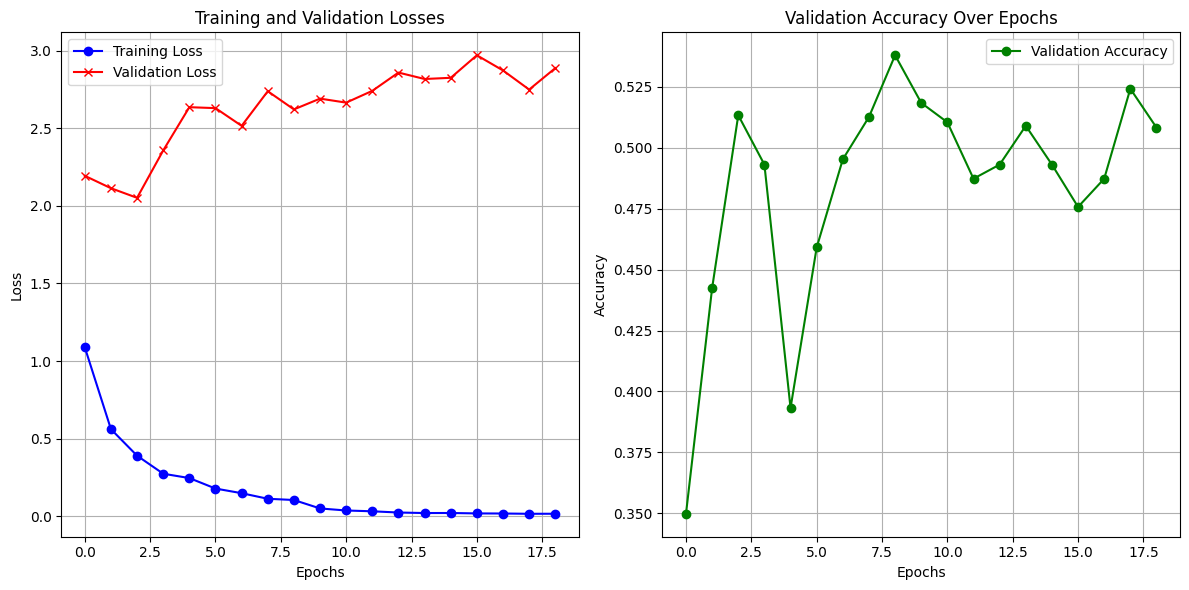

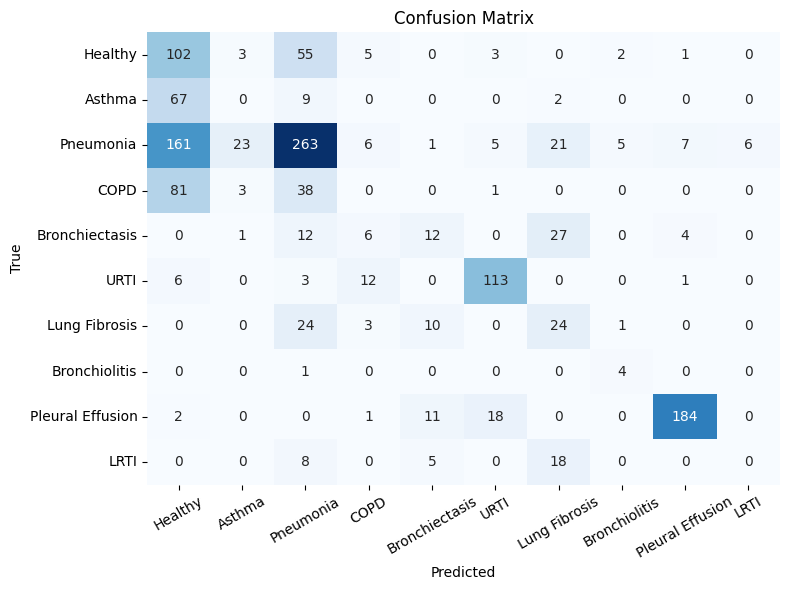

Accuracy: 0.6639
Precision: 0.6053
Recall: 0.686
F1 Score: 0.6128

Test Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.44      0.70      0.54       177
          Asthma       0.33      0.60      0.43         5
       Pneumonia       0.66      0.70      0.68       434
            COPD       0.98      0.52      0.68       279
  Bronchiectasis       1.00      1.00      1.00         5
            URTI       0.86      0.97      0.91       186
   Lung Fibrosis       0.00      0.00      0.00        31
   Bronchiolitis       0.31      1.00      0.48         5
Pleural Effusion       0.47      0.37      0.41        78
            LRTI       1.00      1.00      1.00         5

        accuracy                           0.66      1205
       macro avg       0.61      0.69      0.61      1205
    weighted avg       0.70      0.66      0.66      1205



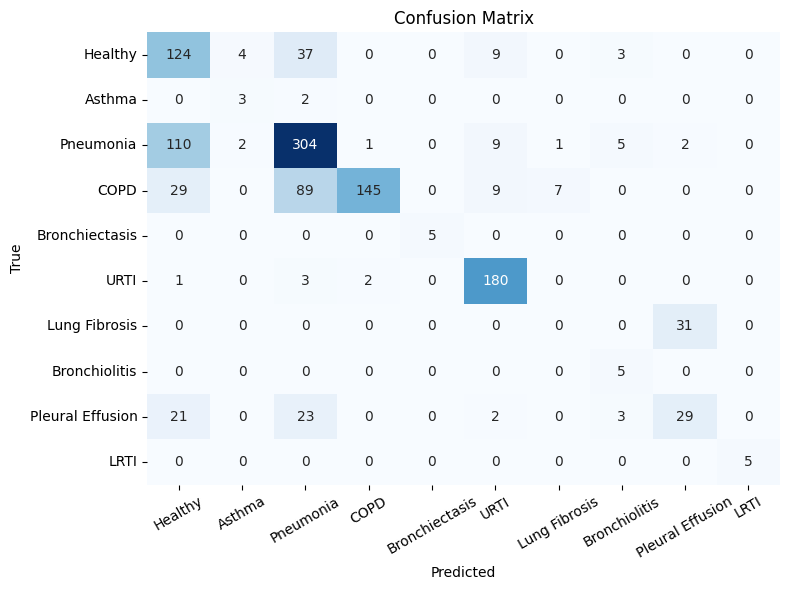

Test Accuracy for DenseNet121: 0.6639004149377593
F1 Score for DenseNet121: 0.6128007819348337


In [ ]:

# Train and evaluate DenseNet121
print("\nTraining DenseNet121...")
model_densenet121 = PretrainedModel('densenet121', num_classes=10,input_channels=3).to(device)
optimizer_densenet121 = optim.AdamW(model_densenet121.parameters(), lr=5e-5, weight_decay=1e-5)

scheduler_densenet121 = ReduceLROnPlateau(optimizer_densenet121, mode='min', patience=5, factor=0.1)
criterion_densenet121 = nn.CrossEntropyLoss(weight=weights_tensor)



train_model(model_densenet121, train_loader, val_loader, criterion_densenet121, optimizer_densenet121, scheduler=scheduler_densenet121,num_epochs=num_epochs, patience=patience,class_names=class_names)
test_acc_densenet121,f1_densenet121 = evaluate_model(model_densenet121, test_loader,device, class_names)
print(f"Test Accuracy for DenseNet121: {test_acc_densenet121}")
print(f"F1 Score for DenseNet121: {f1_densenet121}")

###Metrics Dataframe

In [ ]:
# Create the metrics list for multiple models
metrics_list = [
    {'Model': 'CustomCNN', 'Test Accuracy': np.round(0.5219917012448133,4), 'F1 Score': np.round(0.4552017333855794,4)},
    {'Model': 'ResNet50', 'Test Accuracy': np.round(0.7435684647302905,4), 'F1 Score': np.round(0.674816853839485,4)},
    {'Model': 'DenseNet121', 'Test Accuracy': test_acc_densenet121, 'F1 Score': f1_densenet121},
]

# Convert the metrics list to a DataFrame
metrics_df = pd.DataFrame(metrics_list)

# Display the DataFrame
metrics_df



,Model,Test Accuracy,F1 Score
0,CustomCNN,0.5220,0.455200
1,ResNet50,0.7436,0.674800
2,DenseNet121,0.6639,0.612801


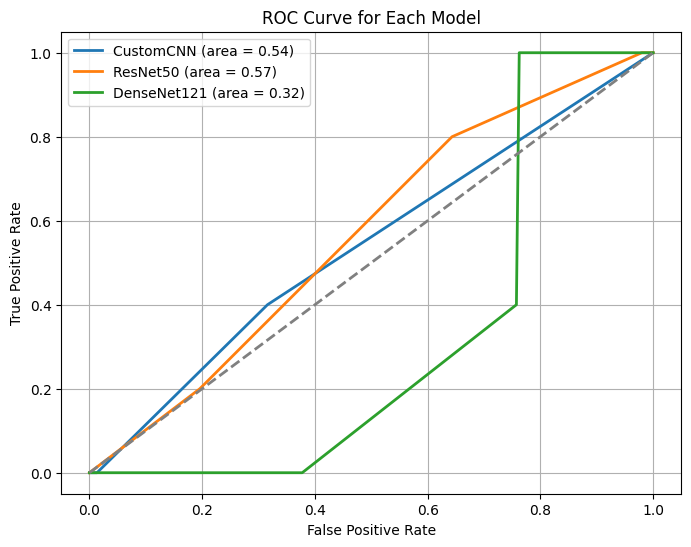

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Plot ROC Curve for Individual Models and Label Pretrained Model Names
def plot_individual_roc_curves(models, model_names, test_loader, device):
    plt.figure(figsize=(8, 6))

    # Iterate over the models and plot each ROC curve with its corresponding name
    for model, model_name in zip(models, model_names):
        model.eval()
        test_labels = []
        test_preds = []

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                test_labels.extend(labels.cpu().numpy())
                test_preds.extend(preds.cpu().numpy())

        # Compute ROC curve for the current model
        fpr, tpr, _ = roc_curve(test_labels, test_preds, pos_label=1)
        roc_auc = auc(fpr, tpr)

        # Plot ROC curve for the current model, using the model name in the label
        plt.plot(fpr, tpr, lw=2, label=f'{model_name} (area = {roc_auc:.2f})')

    # Plot diagonal line for random classifier
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Each Model')
    plt.legend(loc="upper left")
    plt.grid(True)
    plt.show()

# Now plot the ROC curves for each model
# Assuming you have the trained models in the list 'models'
models = [custom_cnn_model, model_resnet50,model_densenet121]
model_names = ['CustomCNN', 'ResNet50', 'DenseNet121']
plot_individual_roc_curves(models, model_names, test_loader, device)
